In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm

import numpy as np
import copy
import json

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
USE_CUDA = True

In [2]:
def readfile(data):
    with open(data, "r", encoding="utf-8") as f:
        content = f.read().splitlines()
        
    return content

def schema_load(schema_root):
    raw_dict = "".join(readfile(schema_root))
    dict2json = "".join(raw_dict.split()[2:])

    json_acceptable_string = dict2json.replace("'", "\"")
    schema = json.loads(json_acceptable_string)
    
    return schema

def define_entity(schema):
    tag_type = list(schema['tagging'])
    
    entity_tag = []
    for k in list(schema['entity'].keys()):
        entity_tag.append(schema['entity'][k]['tag'])
        
    TAG = []
    for t in tag_type:
        for e in entity_tag:
            if t!='O':
                TAG.append(t+'-'+e)  
                
    TAG = [UNKOWN_TAG, PAD_TAG] + TAG + ['O']   

    return TAG

def tag2ix(TAG):
    tag_to_ix={t:i for i,t in enumerate(TAG)}
    return tag_to_ix

def define_relation(schema):
    relation_type = list(schema['relation'])
    
    relation_tag = []
    for k in list(schema['relation'].keys()):
        relation_tag.append(schema['relation'][k]['tag'])
    
    relation_tag = [REL_PAD] + [REL_NONE] + relation_tag
        
    return relation_tag

# ==================================================

def get_word_and_label(_content, start_w, end_w):
    word_list = []
    ent_list = []
    rel_list = []
    
    for word_set in _content[start_w:end_w]:
        word_set = word_set.split()
        if len(word_set)==1:
            word_list.append(' ')
            ent_list.append('O')
            rel_list.append(REL_NONE)
        
        else:
            word_list.append(word_set[0])
            ent_list.append(word_set[1])

            try:
                testerror = word_set[2]
            except IndexError:
                rel_list.append(REL_NONE)
            else:
                rel_list.append(word_set[2:])
    
    return word_list, ent_list, rel_list

def split_to_list(content):
    init = 0
    word_list = []
    ent_list = []
    rel_list = []

    for now_token, c in enumerate(content):
        if c=='':
            words, ents, rels = get_word_and_label(content, init, now_token)
            init = now_token+1
            word_list.append(words)
            ent_list.append(ents)
            rel_list.append(rels)
            
    return word_list, ent_list, rel_list

# ==================================================

def word2index(word_list):
    word_to_ix = {"<UNKNOWN>":0, "<PAD>":1}
    for sentence in word_list:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
                
    return word_to_ix

def dict_inverse(tag_to_ix):
    ix_to_tag = {v: k for k, v in tag_to_ix.items()}
    return ix_to_tag

def index2tag(indexs, ix_to):
    to_tags = [ix_to[i] for i in indexs.cpu().numpy()]
    return to_tags

# ==================================================

def find_max_len(word_list):
    max_len = 0
    for i in range(len(word_list)):
        if max_len<len(word_list[i]):
            max_len=len(word_list[i])
            
    return max_len

# ====== filter the length of sentence more than MAX_LEN =======

def filter_len(word_list):
    reserved_index = []
    for i in range(len(word_list)):
        if len(word_list[i])<MAX_LEN:
            reserved_index.append(i)
            
    return reserved_index


def filter_sentence(reserved_index, word_list, ent_list, rel_list):
    filter_word = list(word_list[i] for i in reserved_index)
    filter_ent = list(ent_list[i] for i in reserved_index)
    filter_rel = list(rel_list[i] for i in reserved_index)
    return filter_word, filter_ent, filter_rel

# ==================================================

def pad_seq(seq, isrel):
    if isrel:
        seq += [REL_NONE for i in range(MAX_LEN-len(seq))]
    else:
        seq += [PAD_TAG for i in range(MAX_LEN-len(seq))]
    return seq

def pad_all(filter_word, filter_ent, filter_rel):
    input_padded = [pad_seq(s, False) for s in filter_word]
    ent_padded = [pad_seq(s, False) for s in filter_ent]
    rel_padded = [pad_seq(s, True) for s in filter_rel]
    
    return input_padded, ent_padded, rel_padded

def deep_copy_lists(filter_word, filter_ent, filter_rel):
    f_w = copy.deepcopy(filter_word)
    f_e = copy.deepcopy(filter_ent)
    f_r = copy.deepcopy(filter_rel)
    
    return f_w, f_e, f_r

# ==================================================

def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix[UNKOWN_TAG])
        else:
            idxs.append(to_ix[w])
    
#     idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_all(seqs, to_ix):
    seq_list = []
    for i in range(len(seqs)):
        seq_list.append(prepare_sequence(seqs[i], to_ix))
        
    seq_list = torch.stack(seq_list)
        
    return seq_list



def prepare_rel(rel_padded, to_ix):
    
    rel_ptr = torch.zeros(len(rel_padded), MAX_LEN, MAX_LEN, dtype=torch.long) 
    
    # 對當前的token，去比較之前所有出現過的entity，是否有關係，建成矩陣
    # [B*ML*ML]，第二維ML是當前token，第三維ML是根據當前token對之前出現過的entity紀錄關係，以index紀錄
    for i, rel_seq in enumerate(rel_padded):
        rel_dict = {}
        for j, token_seq in enumerate(rel_seq):
            rel_ptr[i][j][:j+1] = 1
            if token_seq != REL_NONE:
                for k, rel in enumerate(token_seq):

                    # if 是第一次出現，紀錄後面數字(標第幾對)和關係位置(A OR B)
                    # 假如下次出現又是同個關係位置(A)，依然紀錄
                    # 直到下次出現關係位置B，依照之前紀錄的A位置的字，然後在第三維去標關係

                    rel_token = rel.split('-')
                    if rel_token[1] not in rel_dict:
                        rel_dict[rel_token[1]] = {'rel':rel_token[0], 'loc':rel_token[2], 'idx':[j]}

                    elif rel_token[1] in rel_dict and rel_dict[rel_token[1]]['loc']==rel_token[2]:
                        rel_dict[rel_token[1]]['idx'].append(j)

                    else:
                        record_loc = rel_dict[rel_token[1]]['idx']
                        for idxx in record_loc:
                            rel_ptr[i][j][idxx] = to_ix[rel_token[0]]
                            
    return rel_ptr
                


# ==================================================

def dataload(input_var, ent_var, rel_var, raw_input):
    torch_dataset = Data.TensorDataset(input_var, ent_var, rel_var, raw_input)

    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               
        num_workers=0,       
#         drop_last=True
    )
    
    return loader

# ==================================================
def softmax_entity(entity):
    entity = entity.view(BATCH_SIZE,ent_size).argmax(1)
    return entity

In [3]:
class Attn(nn.Module):
    def __init__(self, attn_input, attn_output, rel_size):
        super(Attn, self).__init__()
        
        self.attn_input = attn_input
        self.attn_output = attn_output
        self.rel_size = rel_size
        
        self.w1 = nn.Linear(self.attn_input, self.attn_output, )# bias=False)
        self.w2 = nn.Linear(self.attn_input, self.attn_output, )# bias=False)
        self.tanh = nn.Tanh()
        self.v = nn.Linear(self.attn_output, self.rel_size, )# bias=False)
        self.softmax = nn.LogSoftmax(dim=2)
        
        
    def forward(self, encoder_outputs):
        
        decoder = encoder_outputs[:,-1,:].unsqueeze(1)                       #B*1*(ts+LE) [128,1,8]
        encoder_score = self.w1(encoder_outputs)                             #B*now len*ATTN_OUT
        decoder_score = self.w2(decoder)                                     #B*1*ATTN_OUT
        energy = self.tanh(encoder_score+decoder_score)                      #B*now len*ATTN_OUT            
        
        energy = self.v(energy)                                              #B*now len*rel_size
        
        
        # 針對每個entity做softmax，去顯示他們的關係權重
        # 主要都會是rel_none
        # 對第二維(rel)做softmax
        p = self.softmax(energy)                                         #B*now len*rel_size
        
        return p
    

In [4]:
class Entity_Typing(nn.Module):
    def __init__(self, vocab_size, ent_tag_to_ix, embedding_dim, hidden_dim1, hidden_dim2, \
                 label_embed_dim, rel_tag_to_ix):
        
        super(Entity_Typing, self).__init__()
        self.embedding_dim = embedding_dim                   #E
        self.hidden_dim1 = hidden_dim1                       #h1
        self.hidden_dim2 = hidden_dim2                       #h2
        self.label_embed_dim = label_embed_dim               #LE
        self.vocab_size = vocab_size                         #vs
        self.ent_to_ix = ent_tag_to_ix
        self.ent_size = len(ent_tag_to_ix)                   #es
        self.rel_to_ix = rel_tag_to_ix
        self.rel_size = len(rel_tag_to_ix)                   #rs           
        
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(hidden_dim1, momentum=0.5, affine=False)
        
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
#         self.bilstm = nn.LSTM(embedding_dim, hidden_dim1 // 2,
#                             num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)        
        self.bilstm = nn.GRU(embedding_dim, hidden_dim1 // 2,
                            num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        
        
        self.dense = nn.Linear(hidden_dim1, DENSE_OUT)
        self.top_hidden = nn.LSTMCell(DENSE_OUT+label_embed_dim, hidden_dim2)          
        

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim2, self.ent_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.label_embed = nn.Linear(self.ent_size, self.label_embed_dim)
        
        self.attn = Attn(ATTN_IN, ATTN_OUT, self.rel_size)
        
        
    def init_hidden1(self):       
        hidden = torch.randn(2*2, self.batch, self.hidden_dim1 // 2)    #4*B*(h1/2)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_hidden2(self):       
        hidden = torch.randn(self.batch, self.hidden_dim2)              #B*h2

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_label_embed(self):
        hidden = torch.zeros(self.batch, self.label_embed_dim)          #B*LE
        return hidden.cuda()if USE_CUDA else hidden
    
    def create_entity(self):
        output_tensor = torch.zeros(self.batch, MAX_LEN, self.ent_size)  #B*ML*es
        return output_tensor.cuda()if USE_CUDA else output_tensor
    
    def create_rel_matrix(self):
        rel_tensor = torch.zeros(self.batch, MAX_LEN, MAX_LEN, self.rel_size)  #B*ML*ML*rs
        return rel_tensor.cuda()if USE_CUDA else rel_tensor
    
    
        
    def forward(self, sentence, batch_ent, isTrain=True):
        
        self.batch = sentence.size(0)
#         self.hidden1 = self.init_hidden1()                      #4*B*(h1/2)
        entity_tensor = self.create_entity()                    #B*ML*es
        rel_tensor = self.create_rel_matrix()                   #B*ML*ML*rs
        
        

        embeds = self.word_embeds(sentence)                     #B*ML*E,[128, 100, 20]
        
#         bilstm_out, self.hidden1 = self.bilstm(embeds, self.hidden1)
        bilstm_out, hidden1 = self.bilstm(embeds)
        # bilstm_out -> B*ML*h1,[128, 100, 10]
        # self.hidden1 -> ( 4*B*(h1/2), 4*B*(h1/2) )
        
        bilstm_out = torch.transpose(bilstm_out, 1, 2)
        # bn
        bilstm_out = self.bn(bilstm_out)
        bilstm_out = torch.transpose(bilstm_out, 1, 2)
        dense_out = self.dense(bilstm_out)                      #B*ML*DENSE_OUT,[128, 100, 100]
        
        
        encoder_sequence_l = [] 

        for length in range(MAX_LEN):
            now_token = dense_out[:,length,:]
            now_token = torch.squeeze(now_token, 1)
            
            if length==0:
                self.hidden2 = self.init_hidden2()
                self.zero_label_embed = self.init_label_embed()
                combine_x = torch.cat((now_token, self.zero_label_embed),1)  #B*(DENSE_OUT+LE),[128, 103]
                
            else:
                self.hidden2 = (h_next, c_next)
                combine_x = torch.cat((now_token, label),1)

            h_next, c_next = self.top_hidden(combine_x, self.hidden2)    #B*h2,[128, 8]           
            to_tags = self.hidden2tag(h_next)                            #B*es,[128, 5]            
            ent_output = self.softmax(to_tags)                               #B*es,[128, 5]  
            s_ent_output = self.softmax_entity(ent_output)
            ent_onehot = self.one_hot(s_ent_output)
            
            
            if isTrain:
                label = self.label_embed(ent_onehot)                             #B*LE,[128, 3]
#                 label = self.label_embed(ent_output) 
            else:
                batch_ent_onehot = self.one_hot(batch_ent[:,length])
                label = self.label_embed(batch_ent_onehot)
            
     
            
            # Assignments to Variables are in-place operations.
            # Use that variable in lots of other contexts 
            # and some of the functions require it to not change. 
            to_tags_clone = to_tags.clone()
            label_clone = label.clone()
            
            
#             for i, tag in enumerate(s_ent_output):
#                 if tag==ent_tag_to_ix['O']:
#                     to_tags_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
#                     label_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
                    
            # relation layer
#             encoder_sequence_l.append(torch.cat((to_tags,label),1)) 
            encoder_sequence_l.append(torch.cat((h_next,label),1))  
            encoder_sequence = torch.stack(encoder_sequence_l).t()     #B*len*(es+LE), [128,1,8]          

            # Calculate attention weights 
            attn_weights = self.attn(encoder_sequence)

        
            entity_tensor[:,length,:] = ent_output
            
            # rel_tensor[:,length, 頭~當前 ,:]
            rel_tensor[:,length,:length+1,:] = attn_weights

        
        
        '''NLLLoss input: Input: (N,C) where C = number of classes'''
        return entity_tensor.view(self.batch*MAX_LEN, self.ent_size), \
               rel_tensor.view(self.batch*MAX_LEN*MAX_LEN, self.rel_size)
        
        
    def softmax_entity(self, entity):
        entity = entity.view(self.batch,ent_size).argmax(1)
        return entity
    
    
    def one_hot(self, batch_ent):   
        batchsize = batch_ent.size(0)
        nb_digits = len(ent_tag_to_ix)
        batch_ent = torch.unsqueeze(batch_ent, 1)
        y_onehot = torch.cuda.FloatTensor(batchsize, nb_digits)        
        y_onehot.zero_()
        y_onehot.scatter_(1, batch_ent, 1)    

        return y_onehot

In [5]:
root = '/notebooks/sinica/dataset/'

schema_root = root+'schema2.txt'

relation_data = root+'skincare_mr.train'
dev_data = root+'skincare_mr.dev'
test_data = root+'skincare_mr.test'

# relation_data = root+'facial_r3.train'
# dev_data = root+'facial_r3.dev'
# test_data = root+'skincare.dev'



UNKOWN_TAG = "<UNKNOWN>"
PAD_TAG = "<PAD>"
REL_NONE = 'Rel-None'
REL_PAD = 'Rel-Pad'

schema = schema_load(schema_root)
ENT_TAG = define_entity(schema)
REL_TAG = define_relation(schema)
ent_tag_to_ix = tag2ix(ENT_TAG)
'''{'<PAD>': 1,
 '<UNKNOWN>': 0,
 'B-FUNC': 2,
 'B-STAT': 3,
 'I-FUNC': 4,
 'I-STAT': 5,
 'O': 6}'''
rel_tag_to_ix = tag2ix(REL_TAG)
'''{'ApplyTo': 2, 'Rel-None': 1, 'Rel-Pad': 0}'''

# ========hyper-parameter-set==========

ent_size = len(ent_tag_to_ix)
rel_size = len(rel_tag_to_ix)
MAX_LEN = 100     # original 100
BATCH_SIZE = 32

EMBEDDING_DIM = 40   # original 40
HIDDEN_DIM1 = 20     # original 20
HIDDEN_DIM2 = 16     # original 16
LABEL_EMBED_DIM = ent_size
DENSE_OUT = 100

# ATTN_IN = ent_size+LABEL_EMBED_DIM
ATTN_IN = HIDDEN_DIM2+LABEL_EMBED_DIM
ATTN_OUT = 64        # original 6       

In [6]:
def preprocess(data):
    content = readfile(data)
    word_list, ent_list, rel_list = split_to_list(content)
    word_to_ix = word2index(word_list)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    #================================================
    vocab_size = len(word_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, vocab_size, word_to_ix, reserved_index, word_list

def dev_preprocess(dev_data):
    dev_content = readfile(dev_data)
    word_list, ent_list, rel_list = split_to_list(dev_content)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, reserved_index, word_list


In [7]:
ix_to_ent_tag = dict_inverse(ent_tag_to_ix)
ix_to_rel_tag = dict_inverse(rel_tag_to_ix)
#===============================================
input_var, ent_var, rel_var, vocab_size, word_to_ix, raw_index, raw_input = preprocess(relation_data)
loader = dataload(input_var, ent_var, rel_var, raw_index)

input_dev, ent_dev, rel_dev, raw_index_dev, raw_input_dev = dev_preprocess(dev_data)
dev_loader = dataload(input_dev, ent_dev, rel_dev, raw_index_dev)

In [8]:
model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion_tag = nn.NLLLoss(ignore_index=ent_tag_to_ix[PAD_TAG])
criterion_rel = nn.NLLLoss(ignore_index=rel_tag_to_ix[REL_PAD])
# criterion_rel = nn.NLLLoss()

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
n_iters = 350
print_every = 12

train_entloss_l = []
val_entloss_l = []
train_relloss_l = []
val_relloss_l = []

loss = 0
start = time.time()

for epoch in tqdm(range(n_iters)):  
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
        model.train()
        optimizer.zero_grad()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        batch_ent = batch_ent.view(batchsize*MAX_LEN)
        batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)
        
        entloss = criterion_tag(ent_output.cpu(), batch_ent)
        relloss = criterion_rel(rel_output.cpu(), batch_rel)
        loss = entloss+relloss
        
        loss.backward()
#         loss.backward(retain_graph=True)
        optimizer.step()
        

    train_entloss_l.append(entloss.cpu())
    train_relloss_l.append(relloss.cpu())
    #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))
    
    
    del batch_x, batch_ent, batch_rel
    del ent_output, rel_output
    torch.cuda.empty_cache()
        
    
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        val_entloss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
        val_relloss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
        
    val_entloss_l.append(val_entloss.cpu())
    val_relloss_l.append(val_relloss.cpu())
    
    
    print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
          % (epoch+1, entloss, relloss, loss))
    print("      %s  | val ent loss %.4f | val rel loss %.4f"
          % (" "*len(str(epoch+1)), val_entloss, val_relloss))

    
    del entloss, relloss, loss
    del val_entloss, val_relloss
    del batch_x, batch_ent, batch_rel
    del ent_output, rel_output
    torch.cuda.empty_cache()

  0%|          | 1/350 [00:10<1:03:44, 10.96s/it]

epoch: 1 | ent loss 0.6033 | rel loss 0.0100 | total loss 0.6134
         | val ent loss 0.4564 | val rel loss 0.0065


  1%|          | 2/350 [00:21<1:02:01, 10.69s/it]

epoch: 2 | ent loss 0.6268 | rel loss 0.0091 | total loss 0.6359
         | val ent loss 0.5333 | val rel loss 0.0064


  1%|          | 3/350 [00:32<1:01:53, 10.70s/it]

epoch: 3 | ent loss 0.5175 | rel loss 0.0111 | total loss 0.5286
         | val ent loss 0.5300 | val rel loss 0.0033


  1%|          | 4/350 [00:42<1:01:47, 10.72s/it]

epoch: 4 | ent loss 0.5004 | rel loss 0.0049 | total loss 0.5053
         | val ent loss 0.4836 | val rel loss 0.0041


  1%|▏         | 5/350 [00:53<1:01:27, 10.69s/it]

epoch: 5 | ent loss 0.4272 | rel loss 0.0048 | total loss 0.4320
         | val ent loss 0.6540 | val rel loss 0.0070


  2%|▏         | 6/350 [01:03<1:01:00, 10.64s/it]

epoch: 6 | ent loss 0.4172 | rel loss 0.0048 | total loss 0.4220
         | val ent loss 0.4931 | val rel loss 0.0051


  2%|▏         | 7/350 [01:14<1:00:58, 10.67s/it]

epoch: 7 | ent loss 0.4034 | rel loss 0.0063 | total loss 0.4097
         | val ent loss 0.4216 | val rel loss 0.0034


  2%|▏         | 8/350 [01:24<1:00:15, 10.57s/it]

epoch: 8 | ent loss 0.2972 | rel loss 0.0067 | total loss 0.3039
         | val ent loss 0.3144 | val rel loss 0.0059


  3%|▎         | 9/350 [01:33<59:04, 10.40s/it]  

epoch: 9 | ent loss 0.3373 | rel loss 0.0030 | total loss 0.3404
         | val ent loss 0.2638 | val rel loss 0.0032


  3%|▎         | 10/350 [01:43<58:27, 10.32s/it]

epoch: 10 | ent loss 0.3240 | rel loss 0.0042 | total loss 0.3282
          | val ent loss 0.3316 | val rel loss 0.0028


  3%|▎         | 11/350 [01:52<57:47, 10.23s/it]

epoch: 11 | ent loss 0.1792 | rel loss 0.0044 | total loss 0.1836
          | val ent loss 0.2237 | val rel loss 0.0031


  3%|▎         | 12/350 [02:02<57:44, 10.25s/it]

epoch: 12 | ent loss 0.1385 | rel loss 0.0027 | total loss 0.1412
          | val ent loss 0.1264 | val rel loss 0.0028


  4%|▎         | 13/350 [02:13<57:38, 10.26s/it]

epoch: 13 | ent loss 0.1204 | rel loss 0.0023 | total loss 0.1228
          | val ent loss 0.1172 | val rel loss 0.0033


  4%|▍         | 14/350 [02:24<57:40, 10.30s/it]

epoch: 14 | ent loss 0.1008 | rel loss 0.0027 | total loss 0.1035
          | val ent loss 0.0594 | val rel loss 0.0022


  4%|▍         | 15/350 [02:34<57:19, 10.27s/it]

epoch: 15 | ent loss 0.0855 | rel loss 0.0014 | total loss 0.0869
          | val ent loss 0.0978 | val rel loss 0.0027


  5%|▍         | 16/350 [02:44<57:11, 10.27s/it]

epoch: 16 | ent loss 0.1306 | rel loss 0.0034 | total loss 0.1340
          | val ent loss 0.0901 | val rel loss 0.0045


  5%|▍         | 17/350 [02:54<56:58, 10.27s/it]

epoch: 17 | ent loss 0.0753 | rel loss 0.0019 | total loss 0.0772
          | val ent loss 0.0333 | val rel loss 0.0026


  5%|▌         | 18/350 [03:04<56:51, 10.27s/it]

epoch: 18 | ent loss 0.0559 | rel loss 0.0025 | total loss 0.0584
          | val ent loss 0.0853 | val rel loss 0.0014


  5%|▌         | 19/350 [03:15<56:47, 10.29s/it]

epoch: 19 | ent loss 0.0669 | rel loss 0.0029 | total loss 0.0698
          | val ent loss 0.0457 | val rel loss 0.0028


  6%|▌         | 20/350 [03:25<56:37, 10.30s/it]

epoch: 20 | ent loss 0.0799 | rel loss 0.0028 | total loss 0.0827
          | val ent loss 0.1062 | val rel loss 0.0051


  6%|▌         | 21/350 [03:35<56:22, 10.28s/it]

epoch: 21 | ent loss 0.0620 | rel loss 0.0024 | total loss 0.0644
          | val ent loss 0.0325 | val rel loss 0.0013


  6%|▋         | 22/350 [03:46<56:09, 10.27s/it]

epoch: 22 | ent loss 0.0463 | rel loss 0.0021 | total loss 0.0484
          | val ent loss 0.1294 | val rel loss 0.0023


  7%|▋         | 23/350 [03:56<56:01, 10.28s/it]

epoch: 23 | ent loss 0.0392 | rel loss 0.0018 | total loss 0.0409
          | val ent loss 0.0323 | val rel loss 0.0017


  7%|▋         | 24/350 [04:07<55:55, 10.29s/it]

epoch: 24 | ent loss 0.0243 | rel loss 0.0016 | total loss 0.0259
          | val ent loss 0.0390 | val rel loss 0.0026


  7%|▋         | 25/350 [04:16<55:37, 10.27s/it]

epoch: 25 | ent loss 0.0395 | rel loss 0.0021 | total loss 0.0416
          | val ent loss 0.0755 | val rel loss 0.0021


  7%|▋         | 26/350 [04:26<55:22, 10.26s/it]

epoch: 26 | ent loss 0.0135 | rel loss 0.0021 | total loss 0.0156
          | val ent loss 0.0494 | val rel loss 0.0011


  8%|▊         | 27/350 [04:36<55:05, 10.23s/it]

epoch: 27 | ent loss 0.0370 | rel loss 0.0020 | total loss 0.0390
          | val ent loss 0.0107 | val rel loss 0.0024


  8%|▊         | 28/350 [04:46<54:50, 10.22s/it]

epoch: 28 | ent loss 0.0430 | rel loss 0.0012 | total loss 0.0442
          | val ent loss 0.0167 | val rel loss 0.0005


  8%|▊         | 29/350 [04:56<54:41, 10.22s/it]

epoch: 29 | ent loss 0.0184 | rel loss 0.0018 | total loss 0.0201
          | val ent loss 0.0304 | val rel loss 0.0025


  9%|▊         | 30/350 [05:06<54:33, 10.23s/it]

epoch: 30 | ent loss 0.0283 | rel loss 0.0016 | total loss 0.0298
          | val ent loss 0.0383 | val rel loss 0.0024


  9%|▉         | 31/350 [05:16<54:14, 10.20s/it]

epoch: 31 | ent loss 0.0140 | rel loss 0.0013 | total loss 0.0153
          | val ent loss 0.0414 | val rel loss 0.0003


  9%|▉         | 32/350 [05:25<53:51, 10.16s/it]

epoch: 32 | ent loss 0.0209 | rel loss 0.0011 | total loss 0.0220
          | val ent loss 0.1244 | val rel loss 0.0012


  9%|▉         | 33/350 [05:35<53:42, 10.17s/it]

epoch: 33 | ent loss 0.0344 | rel loss 0.0017 | total loss 0.0361
          | val ent loss 0.0421 | val rel loss 0.0014


 10%|▉         | 34/350 [05:45<53:27, 10.15s/it]

epoch: 34 | ent loss 0.0317 | rel loss 0.0019 | total loss 0.0336
          | val ent loss 0.1386 | val rel loss 0.0019


 10%|█         | 35/350 [05:55<53:17, 10.15s/it]

epoch: 35 | ent loss 0.0086 | rel loss 0.0014 | total loss 0.0100
          | val ent loss 0.0106 | val rel loss 0.0018


 10%|█         | 36/350 [06:03<52:51, 10.10s/it]

epoch: 36 | ent loss 0.0622 | rel loss 0.0009 | total loss 0.0631
          | val ent loss 0.0818 | val rel loss 0.0035


 11%|█         | 37/350 [06:13<52:42, 10.10s/it]

epoch: 37 | ent loss 0.0065 | rel loss 0.0010 | total loss 0.0075
          | val ent loss 0.0308 | val rel loss 0.0029


 11%|█         | 38/350 [06:24<52:33, 10.11s/it]

epoch: 38 | ent loss 0.0640 | rel loss 0.0019 | total loss 0.0658
          | val ent loss 0.0413 | val rel loss 0.0016


 11%|█         | 39/350 [06:33<52:15, 10.08s/it]

epoch: 39 | ent loss 0.0134 | rel loss 0.0016 | total loss 0.0151
          | val ent loss 0.1206 | val rel loss 0.0015


 11%|█▏        | 40/350 [06:42<51:59, 10.06s/it]

epoch: 40 | ent loss 0.0491 | rel loss 0.0010 | total loss 0.0501
          | val ent loss 0.0290 | val rel loss 0.0022


 12%|█▏        | 41/350 [06:53<51:54, 10.08s/it]

epoch: 41 | ent loss 0.0332 | rel loss 0.0021 | total loss 0.0353
          | val ent loss 0.0069 | val rel loss 0.0013


 12%|█▏        | 42/350 [07:02<51:36, 10.05s/it]

epoch: 42 | ent loss 0.0379 | rel loss 0.0012 | total loss 0.0391
          | val ent loss 0.0050 | val rel loss 0.0002


 12%|█▏        | 43/350 [07:11<51:17, 10.02s/it]

epoch: 43 | ent loss 0.0303 | rel loss 0.0013 | total loss 0.0316
          | val ent loss 0.0524 | val rel loss 0.0010


 13%|█▎        | 44/350 [07:21<51:12, 10.04s/it]

epoch: 44 | ent loss 0.0854 | rel loss 0.0030 | total loss 0.0884
          | val ent loss 0.1554 | val rel loss 0.0023


 13%|█▎        | 45/350 [07:31<51:00, 10.03s/it]

epoch: 45 | ent loss 0.0077 | rel loss 0.0010 | total loss 0.0088
          | val ent loss 0.0963 | val rel loss 0.0014


 13%|█▎        | 46/350 [07:41<50:51, 10.04s/it]

epoch: 46 | ent loss 0.0130 | rel loss 0.0022 | total loss 0.0153
          | val ent loss 0.0572 | val rel loss 0.0005


 13%|█▎        | 47/350 [07:52<50:44, 10.05s/it]

epoch: 47 | ent loss 0.0331 | rel loss 0.0014 | total loss 0.0344
          | val ent loss 0.0040 | val rel loss 0.0021


 14%|█▎        | 48/350 [08:02<50:34, 10.05s/it]

epoch: 48 | ent loss 0.0158 | rel loss 0.0013 | total loss 0.0171
          | val ent loss 0.0412 | val rel loss 0.0028


 14%|█▍        | 49/350 [08:12<50:26, 10.06s/it]

epoch: 49 | ent loss 0.0211 | rel loss 0.0009 | total loss 0.0220
          | val ent loss 0.1196 | val rel loss 0.0028


 14%|█▍        | 50/350 [08:22<50:13, 10.04s/it]

epoch: 50 | ent loss 0.0101 | rel loss 0.0012 | total loss 0.0113
          | val ent loss 0.0571 | val rel loss 0.0024


 15%|█▍        | 51/350 [08:32<50:06, 10.05s/it]

epoch: 51 | ent loss 0.0152 | rel loss 0.0017 | total loss 0.0169
          | val ent loss 0.1729 | val rel loss 0.0021


 15%|█▍        | 52/350 [08:41<49:49, 10.03s/it]

epoch: 52 | ent loss 0.0087 | rel loss 0.0012 | total loss 0.0100
          | val ent loss 0.0072 | val rel loss 0.0027


 15%|█▌        | 53/350 [08:50<49:31, 10.00s/it]

epoch: 53 | ent loss 0.0190 | rel loss 0.0007 | total loss 0.0196
          | val ent loss 0.0531 | val rel loss 0.0010


 15%|█▌        | 54/350 [09:00<49:22, 10.01s/it]

epoch: 54 | ent loss 0.0234 | rel loss 0.0014 | total loss 0.0248
          | val ent loss 0.0414 | val rel loss 0.0010


 16%|█▌        | 55/350 [09:10<49:11, 10.01s/it]

epoch: 55 | ent loss 0.0363 | rel loss 0.0018 | total loss 0.0381
          | val ent loss 0.0244 | val rel loss 0.0042


 16%|█▌        | 56/350 [09:19<48:55,  9.98s/it]

epoch: 56 | ent loss 0.0294 | rel loss 0.0014 | total loss 0.0308
          | val ent loss 0.0061 | val rel loss 0.0009


 16%|█▋        | 57/350 [09:28<48:44,  9.98s/it]

epoch: 57 | ent loss 0.0132 | rel loss 0.0007 | total loss 0.0139
          | val ent loss 0.0676 | val rel loss 0.0010


 17%|█▋        | 58/350 [09:38<48:32,  9.97s/it]

epoch: 58 | ent loss 0.0131 | rel loss 0.0011 | total loss 0.0142
          | val ent loss 0.2025 | val rel loss 0.0008


 17%|█▋        | 59/350 [09:48<48:23,  9.98s/it]

epoch: 59 | ent loss 0.0177 | rel loss 0.0017 | total loss 0.0194
          | val ent loss 0.0816 | val rel loss 0.0027


 17%|█▋        | 60/350 [09:58<48:13,  9.98s/it]

epoch: 60 | ent loss 0.0317 | rel loss 0.0020 | total loss 0.0337
          | val ent loss 0.0759 | val rel loss 0.0013


 17%|█▋        | 61/350 [10:09<48:05,  9.98s/it]

epoch: 61 | ent loss 0.0257 | rel loss 0.0013 | total loss 0.0271
          | val ent loss 0.0631 | val rel loss 0.0045


 18%|█▊        | 62/350 [10:19<47:57,  9.99s/it]

epoch: 62 | ent loss 0.0125 | rel loss 0.0014 | total loss 0.0139
          | val ent loss 0.0376 | val rel loss 0.0044


 18%|█▊        | 63/350 [10:29<47:49, 10.00s/it]

epoch: 63 | ent loss 0.0171 | rel loss 0.0008 | total loss 0.0179
          | val ent loss 0.0190 | val rel loss 0.0013


 18%|█▊        | 64/350 [10:39<47:36,  9.99s/it]

epoch: 64 | ent loss 0.0098 | rel loss 0.0013 | total loss 0.0110
          | val ent loss 0.1183 | val rel loss 0.0032


 19%|█▊        | 65/350 [10:49<47:27,  9.99s/it]

epoch: 65 | ent loss 0.0122 | rel loss 0.0010 | total loss 0.0132
          | val ent loss 0.2104 | val rel loss 0.0010


 19%|█▉        | 66/350 [10:59<47:19, 10.00s/it]

epoch: 66 | ent loss 0.0130 | rel loss 0.0012 | total loss 0.0143
          | val ent loss 0.0587 | val rel loss 0.0020


 19%|█▉        | 67/350 [11:10<47:11, 10.00s/it]

epoch: 67 | ent loss 0.0191 | rel loss 0.0014 | total loss 0.0205
          | val ent loss 0.0469 | val rel loss 0.0019


 19%|█▉        | 68/350 [11:19<46:59, 10.00s/it]

epoch: 68 | ent loss 0.0214 | rel loss 0.0015 | total loss 0.0229
          | val ent loss 0.0760 | val rel loss 0.0013


 20%|█▉        | 69/350 [11:30<46:50, 10.00s/it]

epoch: 69 | ent loss 0.0408 | rel loss 0.0021 | total loss 0.0429
          | val ent loss 0.0245 | val rel loss 0.0007


 20%|██        | 70/350 [11:40<46:43, 10.01s/it]

epoch: 70 | ent loss 0.0164 | rel loss 0.0012 | total loss 0.0176
          | val ent loss 0.0810 | val rel loss 0.0031


 20%|██        | 71/350 [11:51<46:34, 10.02s/it]

epoch: 71 | ent loss 0.0119 | rel loss 0.0014 | total loss 0.0133
          | val ent loss 0.1979 | val rel loss 0.0035


 21%|██        | 72/350 [12:01<46:25, 10.02s/it]

epoch: 72 | ent loss 0.0031 | rel loss 0.0012 | total loss 0.0042
          | val ent loss 0.1313 | val rel loss 0.0022


 21%|██        | 73/350 [12:11<46:16, 10.03s/it]

epoch: 73 | ent loss 0.0061 | rel loss 0.0015 | total loss 0.0075
          | val ent loss 0.1330 | val rel loss 0.0022


 21%|██        | 74/350 [12:20<46:03, 10.01s/it]

epoch: 74 | ent loss 0.0083 | rel loss 0.0009 | total loss 0.0092
          | val ent loss 0.0207 | val rel loss 0.0005


 21%|██▏       | 75/350 [12:31<45:55, 10.02s/it]

epoch: 75 | ent loss 0.0035 | rel loss 0.0010 | total loss 0.0045
          | val ent loss 0.0463 | val rel loss 0.0011


 22%|██▏       | 76/350 [12:41<45:46, 10.02s/it]

epoch: 76 | ent loss 0.0336 | rel loss 0.0011 | total loss 0.0347
          | val ent loss 0.0036 | val rel loss 0.0014


 22%|██▏       | 77/350 [12:52<45:37, 10.03s/it]

epoch: 77 | ent loss 0.0278 | rel loss 0.0008 | total loss 0.0286
          | val ent loss 0.1051 | val rel loss 0.0022


 22%|██▏       | 78/350 [13:02<45:28, 10.03s/it]

epoch: 78 | ent loss 0.0093 | rel loss 0.0016 | total loss 0.0109
          | val ent loss 0.0768 | val rel loss 0.0005


 23%|██▎       | 79/350 [13:12<45:17, 10.03s/it]

epoch: 79 | ent loss 0.0034 | rel loss 0.0008 | total loss 0.0043
          | val ent loss 0.0272 | val rel loss 0.0019


 23%|██▎       | 80/350 [13:22<45:07, 10.03s/it]

epoch: 80 | ent loss 0.0214 | rel loss 0.0009 | total loss 0.0223
          | val ent loss 0.0690 | val rel loss 0.0014


 23%|██▎       | 81/350 [13:31<44:55, 10.02s/it]

epoch: 81 | ent loss 0.0108 | rel loss 0.0012 | total loss 0.0120
          | val ent loss 0.0209 | val rel loss 0.0011


 23%|██▎       | 82/350 [13:42<44:46, 10.03s/it]

epoch: 82 | ent loss 0.0117 | rel loss 0.0011 | total loss 0.0128
          | val ent loss 0.1017 | val rel loss 0.0021


 24%|██▎       | 83/350 [13:52<44:38, 10.03s/it]

epoch: 83 | ent loss 0.0046 | rel loss 0.0018 | total loss 0.0063
          | val ent loss 0.0305 | val rel loss 0.0011


 24%|██▍       | 84/350 [14:03<44:29, 10.04s/it]

epoch: 84 | ent loss 0.0037 | rel loss 0.0015 | total loss 0.0051
          | val ent loss 0.0459 | val rel loss 0.0008


 24%|██▍       | 85/350 [14:12<44:17, 10.03s/it]

epoch: 85 | ent loss 0.0040 | rel loss 0.0011 | total loss 0.0051
          | val ent loss 0.0465 | val rel loss 0.0037


 25%|██▍       | 86/350 [14:21<44:04, 10.02s/it]

epoch: 86 | ent loss 0.0036 | rel loss 0.0013 | total loss 0.0049
          | val ent loss 0.0338 | val rel loss 0.0011


 25%|██▍       | 87/350 [14:31<43:55, 10.02s/it]

epoch: 87 | ent loss 0.0139 | rel loss 0.0010 | total loss 0.0150
          | val ent loss 0.1109 | val rel loss 0.0008


 25%|██▌       | 88/350 [14:41<43:45, 10.02s/it]

epoch: 88 | ent loss 0.0081 | rel loss 0.0014 | total loss 0.0095
          | val ent loss 0.0709 | val rel loss 0.0011


 25%|██▌       | 89/350 [14:51<43:35, 10.02s/it]

epoch: 89 | ent loss 0.0024 | rel loss 0.0009 | total loss 0.0033
          | val ent loss 0.0197 | val rel loss 0.0033


 26%|██▌       | 90/350 [15:02<43:26, 10.03s/it]

epoch: 90 | ent loss 0.0019 | rel loss 0.0008 | total loss 0.0027
          | val ent loss 0.0982 | val rel loss 0.0011


 26%|██▌       | 91/350 [15:12<43:16, 10.02s/it]

epoch: 91 | ent loss 0.0140 | rel loss 0.0011 | total loss 0.0151
          | val ent loss 0.0962 | val rel loss 0.0019


 26%|██▋       | 92/350 [15:22<43:08, 10.03s/it]

epoch: 92 | ent loss 0.0084 | rel loss 0.0008 | total loss 0.0092
          | val ent loss 0.0909 | val rel loss 0.0017


 27%|██▋       | 93/350 [15:33<43:00, 10.04s/it]

epoch: 93 | ent loss 0.0077 | rel loss 0.0010 | total loss 0.0087
          | val ent loss 0.1141 | val rel loss 0.0013


 27%|██▋       | 94/350 [15:44<42:50, 10.04s/it]

epoch: 94 | ent loss 0.0151 | rel loss 0.0022 | total loss 0.0173
          | val ent loss 0.0082 | val rel loss 0.0009


 27%|██▋       | 95/350 [15:54<42:43, 10.05s/it]

epoch: 95 | ent loss 0.0039 | rel loss 0.0006 | total loss 0.0045
          | val ent loss 0.1291 | val rel loss 0.0010


 27%|██▋       | 96/350 [16:04<42:31, 10.05s/it]

epoch: 96 | ent loss 0.0101 | rel loss 0.0009 | total loss 0.0110
          | val ent loss 0.0618 | val rel loss 0.0017


 28%|██▊       | 97/350 [16:15<42:23, 10.05s/it]

epoch: 97 | ent loss 0.0164 | rel loss 0.0015 | total loss 0.0178
          | val ent loss 0.3656 | val rel loss 0.0029


 28%|██▊       | 98/350 [16:25<42:13, 10.05s/it]

epoch: 98 | ent loss 0.0124 | rel loss 0.0013 | total loss 0.0137
          | val ent loss 0.0706 | val rel loss 0.0007


 28%|██▊       | 99/350 [16:35<42:04, 10.06s/it]

epoch: 99 | ent loss 0.0036 | rel loss 0.0011 | total loss 0.0047
          | val ent loss 0.0360 | val rel loss 0.0006


 29%|██▊       | 100/350 [16:44<41:52, 10.05s/it]

epoch: 100 | ent loss 0.0066 | rel loss 0.0008 | total loss 0.0074
           | val ent loss 0.0565 | val rel loss 0.0012


 29%|██▉       | 101/350 [16:55<41:43, 10.05s/it]

epoch: 101 | ent loss 0.0065 | rel loss 0.0012 | total loss 0.0076
           | val ent loss 0.0015 | val rel loss 0.0012


 29%|██▉       | 102/350 [17:02<41:26, 10.03s/it]

epoch: 102 | ent loss 0.0117 | rel loss 0.0010 | total loss 0.0127
           | val ent loss 0.0186 | val rel loss 0.0010


 29%|██▉       | 103/350 [17:11<41:14, 10.02s/it]

epoch: 103 | ent loss 0.0093 | rel loss 0.0014 | total loss 0.0107
           | val ent loss 0.1148 | val rel loss 0.0021


 30%|██▉       | 104/350 [17:22<41:06, 10.03s/it]

epoch: 104 | ent loss 0.0109 | rel loss 0.0014 | total loss 0.0123
           | val ent loss 0.0320 | val rel loss 0.0005


 30%|███       | 105/350 [17:33<40:57, 10.03s/it]

epoch: 105 | ent loss 0.0083 | rel loss 0.0007 | total loss 0.0091
           | val ent loss 0.0873 | val rel loss 0.0019


 30%|███       | 106/350 [17:43<40:48, 10.03s/it]

epoch: 106 | ent loss 0.0140 | rel loss 0.0019 | total loss 0.0159
           | val ent loss 0.0205 | val rel loss 0.0006


 31%|███       | 107/350 [17:53<40:39, 10.04s/it]

epoch: 107 | ent loss 0.0095 | rel loss 0.0010 | total loss 0.0105
           | val ent loss 0.0953 | val rel loss 0.0009


 31%|███       | 108/350 [18:04<40:29, 10.04s/it]

epoch: 108 | ent loss 0.0080 | rel loss 0.0009 | total loss 0.0090
           | val ent loss 0.1081 | val rel loss 0.0006


 31%|███       | 109/350 [18:14<40:20, 10.04s/it]

epoch: 109 | ent loss 0.0087 | rel loss 0.0007 | total loss 0.0094
           | val ent loss 0.0573 | val rel loss 0.0009


 31%|███▏      | 110/350 [18:25<40:11, 10.05s/it]

epoch: 110 | ent loss 0.0084 | rel loss 0.0010 | total loss 0.0094
           | val ent loss 0.1076 | val rel loss 0.0018


 32%|███▏      | 111/350 [18:36<40:02, 10.05s/it]

epoch: 111 | ent loss 0.0051 | rel loss 0.0010 | total loss 0.0061
           | val ent loss 0.0899 | val rel loss 0.0017


 32%|███▏      | 112/350 [18:46<39:54, 10.06s/it]

epoch: 112 | ent loss 0.0045 | rel loss 0.0007 | total loss 0.0051
           | val ent loss 0.0364 | val rel loss 0.0012


 32%|███▏      | 113/350 [18:55<39:40, 10.04s/it]

epoch: 113 | ent loss 0.0066 | rel loss 0.0006 | total loss 0.0072
           | val ent loss 0.0429 | val rel loss 0.0025


 33%|███▎      | 114/350 [19:05<39:30, 10.04s/it]

epoch: 114 | ent loss 0.0079 | rel loss 0.0009 | total loss 0.0088
           | val ent loss 0.0355 | val rel loss 0.0014


 33%|███▎      | 115/350 [19:15<39:21, 10.05s/it]

epoch: 115 | ent loss 0.0354 | rel loss 0.0010 | total loss 0.0364
           | val ent loss 0.2322 | val rel loss 0.0007


 33%|███▎      | 116/350 [19:26<39:12, 10.05s/it]

epoch: 116 | ent loss 0.0094 | rel loss 0.0011 | total loss 0.0104
           | val ent loss 0.0139 | val rel loss 0.0005


 33%|███▎      | 117/350 [19:36<39:02, 10.06s/it]

epoch: 117 | ent loss 0.0162 | rel loss 0.0011 | total loss 0.0173
           | val ent loss 0.0634 | val rel loss 0.0011


 34%|███▎      | 118/350 [19:44<38:49, 10.04s/it]

epoch: 118 | ent loss 0.0133 | rel loss 0.0007 | total loss 0.0140
           | val ent loss 0.0693 | val rel loss 0.0007


 34%|███▍      | 119/350 [19:54<38:37, 10.03s/it]

epoch: 119 | ent loss 0.0112 | rel loss 0.0019 | total loss 0.0131
           | val ent loss 0.2304 | val rel loss 0.0012


 34%|███▍      | 120/350 [20:03<38:25, 10.03s/it]

epoch: 120 | ent loss 0.0180 | rel loss 0.0015 | total loss 0.0195
           | val ent loss 0.0039 | val rel loss 0.0012


 35%|███▍      | 121/350 [20:13<38:16, 10.03s/it]

epoch: 121 | ent loss 0.0121 | rel loss 0.0010 | total loss 0.0131
           | val ent loss 0.0136 | val rel loss 0.0012


 35%|███▍      | 122/350 [20:24<38:07, 10.03s/it]

epoch: 122 | ent loss 0.0040 | rel loss 0.0010 | total loss 0.0051
           | val ent loss 0.0503 | val rel loss 0.0013


 35%|███▌      | 123/350 [20:34<37:58, 10.04s/it]

epoch: 123 | ent loss 0.0050 | rel loss 0.0008 | total loss 0.0059
           | val ent loss 0.0062 | val rel loss 0.0016


 35%|███▌      | 124/350 [20:44<37:49, 10.04s/it]

epoch: 124 | ent loss 0.0123 | rel loss 0.0019 | total loss 0.0142
           | val ent loss 0.0134 | val rel loss 0.0009


 36%|███▌      | 125/350 [20:54<37:38, 10.04s/it]

epoch: 125 | ent loss 0.0027 | rel loss 0.0011 | total loss 0.0038
           | val ent loss 0.1014 | val rel loss 0.0016


 36%|███▌      | 126/350 [21:05<37:29, 10.04s/it]

epoch: 126 | ent loss 0.0238 | rel loss 0.0015 | total loss 0.0254
           | val ent loss 0.0011 | val rel loss 0.0005


 36%|███▋      | 127/350 [21:16<37:20, 10.05s/it]

epoch: 127 | ent loss 0.0107 | rel loss 0.0016 | total loss 0.0122
           | val ent loss 0.0565 | val rel loss 0.0015


 37%|███▋      | 128/350 [21:26<37:11, 10.05s/it]

epoch: 128 | ent loss 0.0045 | rel loss 0.0012 | total loss 0.0057
           | val ent loss 0.0122 | val rel loss 0.0010


 37%|███▋      | 129/350 [21:34<36:58, 10.04s/it]

epoch: 129 | ent loss 0.0060 | rel loss 0.0010 | total loss 0.0071
           | val ent loss 0.0010 | val rel loss 0.0012


 37%|███▋      | 130/350 [21:42<36:44, 10.02s/it]

epoch: 130 | ent loss 0.0131 | rel loss 0.0007 | total loss 0.0138
           | val ent loss 0.0488 | val rel loss 0.0012


 37%|███▋      | 131/350 [21:52<36:33, 10.02s/it]

epoch: 131 | ent loss 0.0097 | rel loss 0.0012 | total loss 0.0109
           | val ent loss 0.1553 | val rel loss 0.0007


 38%|███▊      | 132/350 [21:59<36:19, 10.00s/it]

epoch: 132 | ent loss 0.0046 | rel loss 0.0007 | total loss 0.0053
           | val ent loss 0.0037 | val rel loss 0.0015


 38%|███▊      | 133/350 [22:09<36:09, 10.00s/it]

epoch: 133 | ent loss 0.0062 | rel loss 0.0010 | total loss 0.0072
           | val ent loss 0.0113 | val rel loss 0.0014


 38%|███▊      | 134/350 [22:18<35:58,  9.99s/it]

epoch: 134 | ent loss 0.0038 | rel loss 0.0010 | total loss 0.0048
           | val ent loss 0.1078 | val rel loss 0.0022


 39%|███▊      | 135/350 [22:27<35:46,  9.98s/it]

epoch: 135 | ent loss 0.0047 | rel loss 0.0011 | total loss 0.0058
           | val ent loss 0.1016 | val rel loss 0.0012


 39%|███▉      | 136/350 [22:37<35:36,  9.98s/it]

epoch: 136 | ent loss 0.0125 | rel loss 0.0012 | total loss 0.0136
           | val ent loss 0.0158 | val rel loss 0.0032


 39%|███▉      | 137/350 [22:48<35:27,  9.99s/it]

epoch: 137 | ent loss 0.0068 | rel loss 0.0008 | total loss 0.0076
           | val ent loss 0.1022 | val rel loss 0.0007


 39%|███▉      | 138/350 [22:58<35:17,  9.99s/it]

epoch: 138 | ent loss 0.0069 | rel loss 0.0006 | total loss 0.0075
           | val ent loss 0.0048 | val rel loss 0.0035


 40%|███▉      | 139/350 [23:07<35:06,  9.99s/it]

epoch: 139 | ent loss 0.0023 | rel loss 0.0010 | total loss 0.0033
           | val ent loss 0.0518 | val rel loss 0.0007


 40%|████      | 140/350 [23:18<34:57,  9.99s/it]

epoch: 140 | ent loss 0.0186 | rel loss 0.0013 | total loss 0.0199
           | val ent loss 0.1216 | val rel loss 0.0034


 40%|████      | 141/350 [23:28<34:48,  9.99s/it]

epoch: 141 | ent loss 0.0223 | rel loss 0.0009 | total loss 0.0232
           | val ent loss 0.1035 | val rel loss 0.0016


 41%|████      | 142/350 [23:39<34:39, 10.00s/it]

epoch: 142 | ent loss 0.0067 | rel loss 0.0015 | total loss 0.0082
           | val ent loss 0.0163 | val rel loss 0.0009


 41%|████      | 143/350 [23:48<34:28,  9.99s/it]

epoch: 143 | ent loss 0.0394 | rel loss 0.0012 | total loss 0.0406
           | val ent loss 0.1215 | val rel loss 0.0012


 41%|████      | 144/350 [23:59<34:18,  9.99s/it]

epoch: 144 | ent loss 0.0070 | rel loss 0.0011 | total loss 0.0081
           | val ent loss 0.0979 | val rel loss 0.0011


 41%|████▏     | 145/350 [24:08<34:07,  9.99s/it]

epoch: 145 | ent loss 0.0174 | rel loss 0.0014 | total loss 0.0188
           | val ent loss 0.2012 | val rel loss 0.0031


 42%|████▏     | 146/350 [24:17<33:56,  9.98s/it]

epoch: 146 | ent loss 0.0096 | rel loss 0.0008 | total loss 0.0104
           | val ent loss 0.2034 | val rel loss 0.0010


 42%|████▏     | 147/350 [24:28<33:47,  9.99s/it]

epoch: 147 | ent loss 0.0187 | rel loss 0.0015 | total loss 0.0202
           | val ent loss 0.0634 | val rel loss 0.0005


 42%|████▏     | 148/350 [24:39<33:38,  9.99s/it]

epoch: 148 | ent loss 0.0065 | rel loss 0.0010 | total loss 0.0075
           | val ent loss 0.1565 | val rel loss 0.0009


 43%|████▎     | 149/350 [24:49<33:29, 10.00s/it]

epoch: 149 | ent loss 0.0194 | rel loss 0.0014 | total loss 0.0207
           | val ent loss 0.0079 | val rel loss 0.0014


 43%|████▎     | 150/350 [24:59<33:18,  9.99s/it]

epoch: 150 | ent loss 0.0032 | rel loss 0.0009 | total loss 0.0041
           | val ent loss 0.1043 | val rel loss 0.0012


 43%|████▎     | 151/350 [25:09<33:09, 10.00s/it]

epoch: 151 | ent loss 0.0064 | rel loss 0.0010 | total loss 0.0073
           | val ent loss 0.1644 | val rel loss 0.0012


 43%|████▎     | 152/350 [25:19<32:58,  9.99s/it]

epoch: 152 | ent loss 0.0049 | rel loss 0.0011 | total loss 0.0059
           | val ent loss 0.0021 | val rel loss 0.0005


 44%|████▎     | 153/350 [25:28<32:48,  9.99s/it]

epoch: 153 | ent loss 0.0103 | rel loss 0.0008 | total loss 0.0112
           | val ent loss 0.0516 | val rel loss 0.0009


 44%|████▍     | 154/350 [25:39<32:39, 10.00s/it]

epoch: 154 | ent loss 0.0224 | rel loss 0.0011 | total loss 0.0235
           | val ent loss 0.0015 | val rel loss 0.0016


 44%|████▍     | 155/350 [25:49<32:29, 10.00s/it]

epoch: 155 | ent loss 0.0066 | rel loss 0.0009 | total loss 0.0075
           | val ent loss 0.0315 | val rel loss 0.0013


 45%|████▍     | 156/350 [25:59<32:19, 10.00s/it]

epoch: 156 | ent loss 0.0086 | rel loss 0.0010 | total loss 0.0096
           | val ent loss 0.0243 | val rel loss 0.0015


 45%|████▍     | 157/350 [26:09<32:09, 10.00s/it]

epoch: 157 | ent loss 0.0099 | rel loss 0.0009 | total loss 0.0108
           | val ent loss 0.0168 | val rel loss 0.0020


 45%|████▌     | 158/350 [26:18<31:57,  9.99s/it]

epoch: 158 | ent loss 0.0038 | rel loss 0.0007 | total loss 0.0045
           | val ent loss 0.0024 | val rel loss 0.0009


 45%|████▌     | 159/350 [26:28<31:48,  9.99s/it]

epoch: 159 | ent loss 0.0036 | rel loss 0.0007 | total loss 0.0043
           | val ent loss 0.0325 | val rel loss 0.0010


 46%|████▌     | 160/350 [26:37<31:37,  9.99s/it]

epoch: 160 | ent loss 0.0018 | rel loss 0.0007 | total loss 0.0026
           | val ent loss 0.0053 | val rel loss 0.0008


 46%|████▌     | 161/350 [26:48<31:28,  9.99s/it]

epoch: 161 | ent loss 0.0042 | rel loss 0.0009 | total loss 0.0051
           | val ent loss 0.2560 | val rel loss 0.0006


 46%|████▋     | 162/350 [26:58<31:18,  9.99s/it]

epoch: 162 | ent loss 0.0067 | rel loss 0.0007 | total loss 0.0074
           | val ent loss 0.0440 | val rel loss 0.0022


 47%|████▋     | 163/350 [27:08<31:08,  9.99s/it]

epoch: 163 | ent loss 0.0034 | rel loss 0.0006 | total loss 0.0040
           | val ent loss 0.1295 | val rel loss 0.0027


 47%|████▋     | 164/350 [27:18<30:58,  9.99s/it]

epoch: 164 | ent loss 0.0017 | rel loss 0.0009 | total loss 0.0027
           | val ent loss 0.1385 | val rel loss 0.0010


 47%|████▋     | 165/350 [27:28<30:48,  9.99s/it]

epoch: 165 | ent loss 0.0047 | rel loss 0.0008 | total loss 0.0055
           | val ent loss 0.0915 | val rel loss 0.0009


 47%|████▋     | 166/350 [27:39<30:39, 10.00s/it]

epoch: 166 | ent loss 0.0160 | rel loss 0.0008 | total loss 0.0168
           | val ent loss 0.1461 | val rel loss 0.0008


 48%|████▊     | 167/350 [27:49<30:29, 10.00s/it]

epoch: 167 | ent loss 0.0019 | rel loss 0.0009 | total loss 0.0028
           | val ent loss 0.0010 | val rel loss 0.0010


 48%|████▊     | 168/350 [28:00<30:20, 10.00s/it]

epoch: 168 | ent loss 0.0039 | rel loss 0.0012 | total loss 0.0051
           | val ent loss 0.0736 | val rel loss 0.0025


 48%|████▊     | 169/350 [28:09<30:09,  9.99s/it]

epoch: 169 | ent loss 0.0212 | rel loss 0.0009 | total loss 0.0221
           | val ent loss 0.1619 | val rel loss 0.0009


 49%|████▊     | 170/350 [28:18<29:58,  9.99s/it]

epoch: 170 | ent loss 0.0061 | rel loss 0.0011 | total loss 0.0073
           | val ent loss 0.2818 | val rel loss 0.0013


 49%|████▉     | 171/350 [28:28<29:48,  9.99s/it]

epoch: 171 | ent loss 0.0174 | rel loss 0.0009 | total loss 0.0183
           | val ent loss 0.1035 | val rel loss 0.0013


 49%|████▉     | 172/350 [28:38<29:38,  9.99s/it]

epoch: 172 | ent loss 0.0100 | rel loss 0.0010 | total loss 0.0111
           | val ent loss 0.0018 | val rel loss 0.0005


 49%|████▉     | 173/350 [28:47<29:27,  9.98s/it]

epoch: 173 | ent loss 0.0033 | rel loss 0.0011 | total loss 0.0043
           | val ent loss 0.0230 | val rel loss 0.0051


 50%|████▉     | 174/350 [28:56<29:16,  9.98s/it]

epoch: 174 | ent loss 0.0168 | rel loss 0.0010 | total loss 0.0178
           | val ent loss 0.0512 | val rel loss 0.0014


 50%|█████     | 175/350 [29:06<29:06,  9.98s/it]

epoch: 175 | ent loss 0.0086 | rel loss 0.0011 | total loss 0.0097
           | val ent loss 0.0352 | val rel loss 0.0014


 50%|█████     | 176/350 [29:17<28:57,  9.98s/it]

epoch: 176 | ent loss 0.0279 | rel loss 0.0017 | total loss 0.0296
           | val ent loss 0.0587 | val rel loss 0.0017


 51%|█████     | 177/350 [29:27<28:47,  9.98s/it]

epoch: 177 | ent loss 0.0020 | rel loss 0.0009 | total loss 0.0029
           | val ent loss 0.0117 | val rel loss 0.0010


 51%|█████     | 178/350 [29:37<28:37,  9.99s/it]

epoch: 178 | ent loss 0.0021 | rel loss 0.0010 | total loss 0.0031
           | val ent loss 0.0851 | val rel loss 0.0020


 51%|█████     | 179/350 [29:48<28:28,  9.99s/it]

epoch: 179 | ent loss 0.0039 | rel loss 0.0009 | total loss 0.0048
           | val ent loss 0.0485 | val rel loss 0.0020


 51%|█████▏    | 180/350 [29:58<28:18,  9.99s/it]

epoch: 180 | ent loss 0.0034 | rel loss 0.0012 | total loss 0.0046
           | val ent loss 0.1537 | val rel loss 0.0021


 52%|█████▏    | 181/350 [30:09<28:09,  9.99s/it]

epoch: 181 | ent loss 0.0047 | rel loss 0.0009 | total loss 0.0056
           | val ent loss 0.0634 | val rel loss 0.0022


 52%|█████▏    | 182/350 [30:18<27:58,  9.99s/it]

epoch: 182 | ent loss 0.0021 | rel loss 0.0007 | total loss 0.0029
           | val ent loss 0.2314 | val rel loss 0.0018


 52%|█████▏    | 183/350 [30:27<27:47,  9.99s/it]

epoch: 183 | ent loss 0.0125 | rel loss 0.0014 | total loss 0.0139
           | val ent loss 0.1020 | val rel loss 0.0030


 53%|█████▎    | 184/350 [30:38<27:38,  9.99s/it]

epoch: 184 | ent loss 0.0084 | rel loss 0.0008 | total loss 0.0092
           | val ent loss 0.0794 | val rel loss 0.0008


 53%|█████▎    | 185/350 [30:48<27:28,  9.99s/it]

epoch: 185 | ent loss 0.0136 | rel loss 0.0015 | total loss 0.0151
           | val ent loss 0.1603 | val rel loss 0.0008


 53%|█████▎    | 186/350 [30:59<27:19, 10.00s/it]

epoch: 186 | ent loss 0.0022 | rel loss 0.0008 | total loss 0.0030
           | val ent loss 0.1044 | val rel loss 0.0029


 53%|█████▎    | 187/350 [31:10<27:10, 10.00s/it]

epoch: 187 | ent loss 0.0146 | rel loss 0.0009 | total loss 0.0155
           | val ent loss 0.0551 | val rel loss 0.0008


 54%|█████▎    | 188/350 [31:20<27:00, 10.00s/it]

epoch: 188 | ent loss 0.0160 | rel loss 0.0017 | total loss 0.0176
           | val ent loss 0.0888 | val rel loss 0.0018


 54%|█████▍    | 189/350 [31:28<26:48,  9.99s/it]

epoch: 189 | ent loss 0.0361 | rel loss 0.0003 | total loss 0.0365
           | val ent loss 0.1079 | val rel loss 0.0009


 54%|█████▍    | 190/350 [31:38<26:38,  9.99s/it]

epoch: 190 | ent loss 0.0027 | rel loss 0.0012 | total loss 0.0038
           | val ent loss 0.0940 | val rel loss 0.0007


 55%|█████▍    | 191/350 [31:49<26:29,  9.99s/it]

epoch: 191 | ent loss 0.0086 | rel loss 0.0006 | total loss 0.0092
           | val ent loss 0.0419 | val rel loss 0.0017


 55%|█████▍    | 192/350 [31:59<26:19, 10.00s/it]

epoch: 192 | ent loss 0.0025 | rel loss 0.0006 | total loss 0.0031
           | val ent loss 0.1134 | val rel loss 0.0005


 55%|█████▌    | 193/350 [32:09<26:09, 10.00s/it]

epoch: 193 | ent loss 0.0013 | rel loss 0.0007 | total loss 0.0021
           | val ent loss 0.1219 | val rel loss 0.0019


 55%|█████▌    | 194/350 [32:18<25:59,  9.99s/it]

epoch: 194 | ent loss 0.0053 | rel loss 0.0007 | total loss 0.0060
           | val ent loss 0.2542 | val rel loss 0.0039


 56%|█████▌    | 195/350 [32:29<25:49, 10.00s/it]

epoch: 195 | ent loss 0.0101 | rel loss 0.0012 | total loss 0.0113
           | val ent loss 0.0436 | val rel loss 0.0014


 56%|█████▌    | 196/350 [32:39<25:39, 10.00s/it]

epoch: 196 | ent loss 0.0131 | rel loss 0.0011 | total loss 0.0142
           | val ent loss 0.1386 | val rel loss 0.0003


 56%|█████▋    | 197/350 [32:48<25:28,  9.99s/it]

epoch: 197 | ent loss 0.0027 | rel loss 0.0011 | total loss 0.0038
           | val ent loss 0.0485 | val rel loss 0.0010


 57%|█████▋    | 198/350 [32:58<25:19,  9.99s/it]

epoch: 198 | ent loss 0.0019 | rel loss 0.0009 | total loss 0.0028
           | val ent loss 0.0018 | val rel loss 0.0006


 57%|█████▋    | 199/350 [33:08<25:09,  9.99s/it]

epoch: 199 | ent loss 0.0024 | rel loss 0.0011 | total loss 0.0036
           | val ent loss 0.0340 | val rel loss 0.0011


 57%|█████▋    | 200/350 [33:16<24:57,  9.98s/it]

epoch: 200 | ent loss 0.0042 | rel loss 0.0012 | total loss 0.0053
           | val ent loss 0.1083 | val rel loss 0.0013


 57%|█████▋    | 201/350 [33:26<24:47,  9.98s/it]

epoch: 201 | ent loss 0.0027 | rel loss 0.0008 | total loss 0.0035
           | val ent loss 0.1468 | val rel loss 0.0034


 58%|█████▊    | 202/350 [33:37<24:37,  9.99s/it]

epoch: 202 | ent loss 0.0017 | rel loss 0.0012 | total loss 0.0029
           | val ent loss 0.1052 | val rel loss 0.0014


 58%|█████▊    | 203/350 [33:47<24:28,  9.99s/it]

epoch: 203 | ent loss 0.0035 | rel loss 0.0008 | total loss 0.0043
           | val ent loss 0.0517 | val rel loss 0.0007


 58%|█████▊    | 204/350 [33:57<24:18,  9.99s/it]

epoch: 204 | ent loss 0.0089 | rel loss 0.0007 | total loss 0.0096
           | val ent loss 0.0981 | val rel loss 0.0007


 59%|█████▊    | 205/350 [34:07<24:08,  9.99s/it]

epoch: 205 | ent loss 0.0041 | rel loss 0.0009 | total loss 0.0050
           | val ent loss 0.0463 | val rel loss 0.0007


 59%|█████▉    | 206/350 [34:18<23:58,  9.99s/it]

epoch: 206 | ent loss 0.0173 | rel loss 0.0021 | total loss 0.0194
           | val ent loss 0.1163 | val rel loss 0.0019


 59%|█████▉    | 207/350 [34:28<23:48,  9.99s/it]

epoch: 207 | ent loss 0.0037 | rel loss 0.0016 | total loss 0.0053
           | val ent loss 0.1222 | val rel loss 0.0024


 59%|█████▉    | 208/350 [34:37<23:38,  9.99s/it]

epoch: 208 | ent loss 0.0133 | rel loss 0.0012 | total loss 0.0145
           | val ent loss 0.0164 | val rel loss 0.0009


 60%|█████▉    | 209/350 [34:47<23:28,  9.99s/it]

epoch: 209 | ent loss 0.0049 | rel loss 0.0012 | total loss 0.0061
           | val ent loss 0.0757 | val rel loss 0.0006


 60%|██████    | 210/350 [34:57<23:18,  9.99s/it]

epoch: 210 | ent loss 0.0032 | rel loss 0.0007 | total loss 0.0040
           | val ent loss 0.0623 | val rel loss 0.0006


 60%|██████    | 211/350 [35:05<23:07,  9.98s/it]

epoch: 211 | ent loss 0.0035 | rel loss 0.0010 | total loss 0.0045
           | val ent loss 0.0012 | val rel loss 0.0007


 61%|██████    | 212/350 [35:15<22:57,  9.98s/it]

epoch: 212 | ent loss 0.0079 | rel loss 0.0006 | total loss 0.0085
           | val ent loss 0.0433 | val rel loss 0.0012


 61%|██████    | 213/350 [35:26<22:47,  9.98s/it]

epoch: 213 | ent loss 0.0050 | rel loss 0.0007 | total loss 0.0057
           | val ent loss 0.0246 | val rel loss 0.0012


 61%|██████    | 214/350 [35:36<22:37,  9.98s/it]

epoch: 214 | ent loss 0.0022 | rel loss 0.0009 | total loss 0.0031
           | val ent loss 0.1500 | val rel loss 0.0016


 61%|██████▏   | 215/350 [35:46<22:27,  9.98s/it]

epoch: 215 | ent loss 0.0026 | rel loss 0.0009 | total loss 0.0035
           | val ent loss 0.2377 | val rel loss 0.0027


 62%|██████▏   | 216/350 [35:56<22:17,  9.98s/it]

epoch: 216 | ent loss 0.0036 | rel loss 0.0013 | total loss 0.0048
           | val ent loss 0.0017 | val rel loss 0.0012


 62%|██████▏   | 217/350 [36:07<22:08,  9.99s/it]

epoch: 217 | ent loss 0.0065 | rel loss 0.0015 | total loss 0.0080
           | val ent loss 0.0171 | val rel loss 0.0018


 62%|██████▏   | 218/350 [36:17<21:58,  9.99s/it]

epoch: 218 | ent loss 0.0050 | rel loss 0.0012 | total loss 0.0062
           | val ent loss 0.1544 | val rel loss 0.0016


 63%|██████▎   | 219/350 [36:27<21:48,  9.99s/it]

epoch: 219 | ent loss 0.0015 | rel loss 0.0005 | total loss 0.0020
           | val ent loss 0.1088 | val rel loss 0.0008


 63%|██████▎   | 220/350 [36:37<21:38,  9.99s/it]

epoch: 220 | ent loss 0.0031 | rel loss 0.0017 | total loss 0.0048
           | val ent loss 0.0046 | val rel loss 0.0013


 63%|██████▎   | 221/350 [36:47<21:28,  9.99s/it]

epoch: 221 | ent loss 0.0088 | rel loss 0.0010 | total loss 0.0098
           | val ent loss 0.0010 | val rel loss 0.0008


 63%|██████▎   | 222/350 [36:57<21:18,  9.99s/it]

epoch: 222 | ent loss 0.0080 | rel loss 0.0014 | total loss 0.0094
           | val ent loss 0.0019 | val rel loss 0.0009


 64%|██████▎   | 223/350 [37:07<21:08,  9.99s/it]

epoch: 223 | ent loss 0.0026 | rel loss 0.0009 | total loss 0.0035
           | val ent loss 0.0758 | val rel loss 0.0021


 64%|██████▍   | 224/350 [37:18<20:58,  9.99s/it]

epoch: 224 | ent loss 0.0024 | rel loss 0.0008 | total loss 0.0031
           | val ent loss 0.0268 | val rel loss 0.0007


 64%|██████▍   | 225/350 [37:27<20:48,  9.99s/it]

epoch: 225 | ent loss 0.0021 | rel loss 0.0006 | total loss 0.0027
           | val ent loss 0.0803 | val rel loss 0.0015


 65%|██████▍   | 226/350 [37:38<20:38,  9.99s/it]

epoch: 226 | ent loss 0.0044 | rel loss 0.0009 | total loss 0.0053
           | val ent loss 0.1767 | val rel loss 0.0027


 65%|██████▍   | 227/350 [37:48<20:29,  9.99s/it]

epoch: 227 | ent loss 0.0063 | rel loss 0.0012 | total loss 0.0075
           | val ent loss 0.0008 | val rel loss 0.0010


 65%|██████▌   | 228/350 [37:57<20:18,  9.99s/it]

epoch: 228 | ent loss 0.0021 | rel loss 0.0009 | total loss 0.0030
           | val ent loss 0.0459 | val rel loss 0.0020


 65%|██████▌   | 229/350 [38:06<20:08,  9.98s/it]

epoch: 229 | ent loss 0.0206 | rel loss 0.0008 | total loss 0.0215
           | val ent loss 0.0279 | val rel loss 0.0031


 66%|██████▌   | 230/350 [38:17<19:58,  9.99s/it]

epoch: 230 | ent loss 0.0094 | rel loss 0.0009 | total loss 0.0103
           | val ent loss 0.1327 | val rel loss 0.0022


 66%|██████▌   | 231/350 [38:27<19:48,  9.99s/it]

epoch: 231 | ent loss 0.0496 | rel loss 0.0016 | total loss 0.0512
           | val ent loss 0.1321 | val rel loss 0.0014


 66%|██████▋   | 232/350 [38:38<19:39,  9.99s/it]

epoch: 232 | ent loss 0.0030 | rel loss 0.0010 | total loss 0.0041
           | val ent loss 0.0119 | val rel loss 0.0018


 67%|██████▋   | 233/350 [38:48<19:29,  9.99s/it]

epoch: 233 | ent loss 0.0010 | rel loss 0.0008 | total loss 0.0019
           | val ent loss 0.0925 | val rel loss 0.0035


 67%|██████▋   | 234/350 [38:58<19:19,  9.99s/it]

epoch: 234 | ent loss 0.0039 | rel loss 0.0011 | total loss 0.0049
           | val ent loss 0.1781 | val rel loss 0.0018


 67%|██████▋   | 235/350 [39:08<19:09,  9.99s/it]

epoch: 235 | ent loss 0.0044 | rel loss 0.0015 | total loss 0.0059
           | val ent loss 0.1025 | val rel loss 0.0009


 67%|██████▋   | 236/350 [39:18<18:59, 10.00s/it]

epoch: 236 | ent loss 0.0030 | rel loss 0.0011 | total loss 0.0041
           | val ent loss 0.0601 | val rel loss 0.0030


 68%|██████▊   | 237/350 [39:28<18:49, 10.00s/it]

epoch: 237 | ent loss 0.0025 | rel loss 0.0011 | total loss 0.0035
           | val ent loss 0.0015 | val rel loss 0.0007


 68%|██████▊   | 238/350 [39:39<18:39, 10.00s/it]

epoch: 238 | ent loss 0.0369 | rel loss 0.0020 | total loss 0.0389
           | val ent loss 0.2000 | val rel loss 0.0030


 68%|██████▊   | 239/350 [39:49<18:29, 10.00s/it]

epoch: 239 | ent loss 0.0128 | rel loss 0.0007 | total loss 0.0135
           | val ent loss 0.0022 | val rel loss 0.0009


 69%|██████▊   | 240/350 [39:59<18:19, 10.00s/it]

epoch: 240 | ent loss 0.0197 | rel loss 0.0011 | total loss 0.0208
           | val ent loss 0.0423 | val rel loss 0.0014


 69%|██████▉   | 241/350 [40:10<18:10, 10.00s/it]

epoch: 241 | ent loss 0.0074 | rel loss 0.0009 | total loss 0.0082
           | val ent loss 0.0034 | val rel loss 0.0005


 69%|██████▉   | 242/350 [40:19<17:59, 10.00s/it]

epoch: 242 | ent loss 0.0027 | rel loss 0.0009 | total loss 0.0036
           | val ent loss 0.1788 | val rel loss 0.0018


 69%|██████▉   | 243/350 [40:29<17:49, 10.00s/it]

epoch: 243 | ent loss 0.0013 | rel loss 0.0008 | total loss 0.0020
           | val ent loss 0.0394 | val rel loss 0.0009


 70%|██████▉   | 244/350 [40:40<17:40, 10.00s/it]

epoch: 244 | ent loss 0.0090 | rel loss 0.0014 | total loss 0.0104
           | val ent loss 0.1378 | val rel loss 0.0010


 70%|███████   | 245/350 [40:49<17:29, 10.00s/it]

epoch: 245 | ent loss 0.0148 | rel loss 0.0009 | total loss 0.0156
           | val ent loss 0.0139 | val rel loss 0.0022


 70%|███████   | 246/350 [41:00<17:20, 10.00s/it]

epoch: 246 | ent loss 0.0029 | rel loss 0.0013 | total loss 0.0042
           | val ent loss 0.0361 | val rel loss 0.0032


 71%|███████   | 247/350 [41:11<17:10, 10.01s/it]

epoch: 247 | ent loss 0.0036 | rel loss 0.0007 | total loss 0.0043
           | val ent loss 0.0259 | val rel loss 0.0010


 71%|███████   | 248/350 [41:19<16:59, 10.00s/it]

epoch: 248 | ent loss 0.0037 | rel loss 0.0008 | total loss 0.0045
           | val ent loss 0.1225 | val rel loss 0.0019


 71%|███████   | 249/350 [41:29<16:49, 10.00s/it]

epoch: 249 | ent loss 0.0035 | rel loss 0.0009 | total loss 0.0044
           | val ent loss 0.1905 | val rel loss 0.0014


 71%|███████▏  | 250/350 [41:38<16:39,  9.99s/it]

epoch: 250 | ent loss 0.0025 | rel loss 0.0008 | total loss 0.0032
           | val ent loss 0.0565 | val rel loss 0.0033


 72%|███████▏  | 251/350 [41:48<16:29, 10.00s/it]

epoch: 251 | ent loss 0.0028 | rel loss 0.0007 | total loss 0.0036
           | val ent loss 0.0012 | val rel loss 0.0005


 72%|███████▏  | 252/350 [41:58<16:19, 10.00s/it]

epoch: 252 | ent loss 0.0016 | rel loss 0.0010 | total loss 0.0026
           | val ent loss 0.0149 | val rel loss 0.0006


 72%|███████▏  | 253/350 [42:09<16:09, 10.00s/it]

epoch: 253 | ent loss 0.0114 | rel loss 0.0008 | total loss 0.0122
           | val ent loss 0.0280 | val rel loss 0.0004


 73%|███████▎  | 254/350 [42:18<15:59,  9.99s/it]

epoch: 254 | ent loss 0.0134 | rel loss 0.0008 | total loss 0.0142
           | val ent loss 0.1686 | val rel loss 0.0009


 73%|███████▎  | 255/350 [42:28<15:49, 10.00s/it]

epoch: 255 | ent loss 0.0182 | rel loss 0.0006 | total loss 0.0188
           | val ent loss 0.1137 | val rel loss 0.0019


 73%|███████▎  | 256/350 [42:39<15:39, 10.00s/it]

epoch: 256 | ent loss 0.0076 | rel loss 0.0019 | total loss 0.0095
           | val ent loss 0.1333 | val rel loss 0.0021


 73%|███████▎  | 257/350 [42:49<15:29, 10.00s/it]

epoch: 257 | ent loss 0.0230 | rel loss 0.0013 | total loss 0.0244
           | val ent loss 0.0421 | val rel loss 0.0023


 74%|███████▎  | 258/350 [42:58<15:19,  9.99s/it]

epoch: 258 | ent loss 0.0024 | rel loss 0.0010 | total loss 0.0034
           | val ent loss 0.2163 | val rel loss 0.0011


 74%|███████▍  | 259/350 [43:07<15:09,  9.99s/it]

epoch: 259 | ent loss 0.0017 | rel loss 0.0008 | total loss 0.0025
           | val ent loss 0.3260 | val rel loss 0.0004


 74%|███████▍  | 260/350 [43:18<14:59,  9.99s/it]

epoch: 260 | ent loss 0.0185 | rel loss 0.0024 | total loss 0.0209
           | val ent loss 0.0409 | val rel loss 0.0012


 75%|███████▍  | 261/350 [43:28<14:49,  9.99s/it]

epoch: 261 | ent loss 0.0128 | rel loss 0.0010 | total loss 0.0138
           | val ent loss 0.0011 | val rel loss 0.0016


 75%|███████▍  | 262/350 [43:38<14:39,  9.99s/it]

epoch: 262 | ent loss 0.0117 | rel loss 0.0014 | total loss 0.0131
           | val ent loss 0.1055 | val rel loss 0.0017


 75%|███████▌  | 263/350 [43:48<14:29, 10.00s/it]

epoch: 263 | ent loss 0.0030 | rel loss 0.0006 | total loss 0.0036
           | val ent loss 0.1010 | val rel loss 0.0016


 75%|███████▌  | 264/350 [43:59<14:19, 10.00s/it]

epoch: 264 | ent loss 0.0014 | rel loss 0.0006 | total loss 0.0020
           | val ent loss 0.1544 | val rel loss 0.0009


 76%|███████▌  | 265/350 [44:08<14:09, 10.00s/it]

epoch: 265 | ent loss 0.0022 | rel loss 0.0008 | total loss 0.0030
           | val ent loss 0.0017 | val rel loss 0.0011


 76%|███████▌  | 266/350 [44:19<13:59, 10.00s/it]

epoch: 266 | ent loss 0.0042 | rel loss 0.0006 | total loss 0.0049
           | val ent loss 0.0502 | val rel loss 0.0011


 76%|███████▋  | 267/350 [44:29<13:49, 10.00s/it]

epoch: 267 | ent loss 0.0032 | rel loss 0.0027 | total loss 0.0059
           | val ent loss 0.0623 | val rel loss 0.0023


 77%|███████▋  | 268/350 [44:38<13:39,  9.99s/it]

epoch: 268 | ent loss 0.0052 | rel loss 0.0013 | total loss 0.0065
           | val ent loss 0.1052 | val rel loss 0.0014


 77%|███████▋  | 269/350 [44:47<13:29,  9.99s/it]

epoch: 269 | ent loss 0.0024 | rel loss 0.0009 | total loss 0.0033
           | val ent loss 0.0012 | val rel loss 0.0006


 77%|███████▋  | 270/350 [44:58<13:19,  9.99s/it]

epoch: 270 | ent loss 0.0015 | rel loss 0.0007 | total loss 0.0022
           | val ent loss 0.0871 | val rel loss 0.0020


 77%|███████▋  | 271/350 [45:09<13:09, 10.00s/it]

epoch: 271 | ent loss 0.0020 | rel loss 0.0007 | total loss 0.0028
           | val ent loss 0.0601 | val rel loss 0.0023


 78%|███████▊  | 272/350 [45:19<12:59, 10.00s/it]

epoch: 272 | ent loss 0.0050 | rel loss 0.0010 | total loss 0.0060
           | val ent loss 0.0670 | val rel loss 0.0008


 78%|███████▊  | 273/350 [45:30<12:50, 10.00s/it]

epoch: 273 | ent loss 0.0034 | rel loss 0.0010 | total loss 0.0044
           | val ent loss 0.0068 | val rel loss 0.0003


 78%|███████▊  | 274/350 [45:41<12:40, 10.00s/it]

epoch: 274 | ent loss 0.0083 | rel loss 0.0012 | total loss 0.0095
           | val ent loss 0.0680 | val rel loss 0.0011


 79%|███████▊  | 275/350 [45:51<12:30, 10.01s/it]

epoch: 275 | ent loss 0.0022 | rel loss 0.0018 | total loss 0.0040
           | val ent loss 0.2141 | val rel loss 0.0012


 79%|███████▉  | 276/350 [46:02<12:20, 10.01s/it]

epoch: 276 | ent loss 0.0055 | rel loss 0.0009 | total loss 0.0065
           | val ent loss 0.0678 | val rel loss 0.0016


 79%|███████▉  | 277/350 [46:11<12:10, 10.01s/it]

epoch: 277 | ent loss 0.0048 | rel loss 0.0010 | total loss 0.0058
           | val ent loss 0.0048 | val rel loss 0.0019


 79%|███████▉  | 278/350 [46:21<12:00, 10.01s/it]

epoch: 278 | ent loss 0.0016 | rel loss 0.0009 | total loss 0.0025
           | val ent loss 0.1247 | val rel loss 0.0035


 80%|███████▉  | 279/350 [46:32<11:50, 10.01s/it]

epoch: 279 | ent loss 0.0266 | rel loss 0.0017 | total loss 0.0283
           | val ent loss 0.0011 | val rel loss 0.0008


 80%|████████  | 280/350 [46:42<11:40, 10.01s/it]

epoch: 280 | ent loss 0.0017 | rel loss 0.0013 | total loss 0.0030
           | val ent loss 0.0869 | val rel loss 0.0016


 80%|████████  | 281/350 [46:53<11:30, 10.01s/it]

epoch: 281 | ent loss 0.0013 | rel loss 0.0011 | total loss 0.0024
           | val ent loss 0.0353 | val rel loss 0.0007


 81%|████████  | 282/350 [47:03<11:20, 10.01s/it]

epoch: 282 | ent loss 0.0135 | rel loss 0.0008 | total loss 0.0143
           | val ent loss 0.0741 | val rel loss 0.0053


 81%|████████  | 283/350 [47:11<11:10, 10.01s/it]

epoch: 283 | ent loss 0.0183 | rel loss 0.0013 | total loss 0.0196
           | val ent loss 0.1047 | val rel loss 0.0026


 81%|████████  | 284/350 [47:22<11:00, 10.01s/it]

epoch: 284 | ent loss 0.0057 | rel loss 0.0011 | total loss 0.0068
           | val ent loss 0.2881 | val rel loss 0.0023


 81%|████████▏ | 285/350 [47:31<10:50, 10.01s/it]

epoch: 285 | ent loss 0.0029 | rel loss 0.0007 | total loss 0.0036
           | val ent loss 0.0012 | val rel loss 0.0011


 82%|████████▏ | 286/350 [47:42<10:40, 10.01s/it]

epoch: 286 | ent loss 0.0030 | rel loss 0.0007 | total loss 0.0037
           | val ent loss 0.2703 | val rel loss 0.0029


 82%|████████▏ | 287/350 [47:53<10:30, 10.01s/it]

epoch: 287 | ent loss 0.0024 | rel loss 0.0009 | total loss 0.0033
           | val ent loss 0.0389 | val rel loss 0.0017


 82%|████████▏ | 288/350 [48:02<10:20, 10.01s/it]

epoch: 288 | ent loss 0.0059 | rel loss 0.0006 | total loss 0.0065
           | val ent loss 0.0014 | val rel loss 0.0014


 83%|████████▎ | 289/350 [48:12<10:10, 10.01s/it]

epoch: 289 | ent loss 0.0055 | rel loss 0.0008 | total loss 0.0063
           | val ent loss 0.0010 | val rel loss 0.0010


 83%|████████▎ | 290/350 [48:23<10:00, 10.01s/it]

epoch: 290 | ent loss 0.0077 | rel loss 0.0010 | total loss 0.0087
           | val ent loss 0.0491 | val rel loss 0.0006


 83%|████████▎ | 291/350 [48:32<09:50, 10.01s/it]

epoch: 291 | ent loss 0.0023 | rel loss 0.0009 | total loss 0.0032
           | val ent loss 0.2337 | val rel loss 0.0017


 83%|████████▎ | 292/350 [48:43<09:40, 10.01s/it]

epoch: 292 | ent loss 0.0047 | rel loss 0.0012 | total loss 0.0059
           | val ent loss 0.0049 | val rel loss 0.0009


 84%|████████▎ | 293/350 [48:54<09:30, 10.01s/it]

epoch: 293 | ent loss 0.0047 | rel loss 0.0009 | total loss 0.0056
           | val ent loss 0.1393 | val rel loss 0.0020


 84%|████████▍ | 294/350 [49:04<09:20, 10.02s/it]

epoch: 294 | ent loss 0.0022 | rel loss 0.0008 | total loss 0.0030
           | val ent loss 0.1419 | val rel loss 0.0027


 84%|████████▍ | 295/350 [49:14<09:10, 10.01s/it]

epoch: 295 | ent loss 0.0015 | rel loss 0.0013 | total loss 0.0028
           | val ent loss 0.0295 | val rel loss 0.0008


 85%|████████▍ | 296/350 [49:24<09:00, 10.02s/it]

epoch: 296 | ent loss 0.0011 | rel loss 0.0008 | total loss 0.0018
           | val ent loss 0.2186 | val rel loss 0.0015


 85%|████████▍ | 297/350 [49:35<08:50, 10.02s/it]

epoch: 297 | ent loss 0.0274 | rel loss 0.0008 | total loss 0.0282
           | val ent loss 0.0618 | val rel loss 0.0005


 85%|████████▌ | 298/350 [49:44<08:40, 10.02s/it]

epoch: 298 | ent loss 0.0113 | rel loss 0.0009 | total loss 0.0122
           | val ent loss 0.0305 | val rel loss 0.0016


 85%|████████▌ | 299/350 [49:53<08:30, 10.01s/it]

epoch: 299 | ent loss 0.0078 | rel loss 0.0008 | total loss 0.0087
           | val ent loss 0.0748 | val rel loss 0.0019


 86%|████████▌ | 300/350 [50:04<08:20, 10.01s/it]

epoch: 300 | ent loss 0.0025 | rel loss 0.0010 | total loss 0.0035
           | val ent loss 0.0712 | val rel loss 0.0010


 86%|████████▌ | 301/350 [50:14<08:10, 10.02s/it]

epoch: 301 | ent loss 0.0129 | rel loss 0.0007 | total loss 0.0136
           | val ent loss 0.0015 | val rel loss 0.0038


 86%|████████▋ | 302/350 [50:24<08:00, 10.02s/it]

epoch: 302 | ent loss 0.0014 | rel loss 0.0007 | total loss 0.0021
           | val ent loss 0.1145 | val rel loss 0.0007


 87%|████████▋ | 303/350 [50:34<07:50, 10.02s/it]

epoch: 303 | ent loss 0.0014 | rel loss 0.0010 | total loss 0.0024
           | val ent loss 0.1200 | val rel loss 0.0021


 87%|████████▋ | 304/350 [50:45<07:40, 10.02s/it]

epoch: 304 | ent loss 0.0041 | rel loss 0.0009 | total loss 0.0050
           | val ent loss 0.1058 | val rel loss 0.0019


 87%|████████▋ | 305/350 [50:55<07:30, 10.02s/it]

epoch: 305 | ent loss 0.0533 | rel loss 0.0010 | total loss 0.0543
           | val ent loss 0.0751 | val rel loss 0.0020


 87%|████████▋ | 306/350 [51:06<07:20, 10.02s/it]

epoch: 306 | ent loss 0.0047 | rel loss 0.0008 | total loss 0.0055
           | val ent loss 0.1445 | val rel loss 0.0022


 88%|████████▊ | 307/350 [51:16<07:10, 10.02s/it]

epoch: 307 | ent loss 0.0029 | rel loss 0.0009 | total loss 0.0038
           | val ent loss 0.0452 | val rel loss 0.0022


 88%|████████▊ | 308/350 [51:27<07:00, 10.02s/it]

epoch: 308 | ent loss 0.0068 | rel loss 0.0009 | total loss 0.0077
           | val ent loss 0.3396 | val rel loss 0.0018


 88%|████████▊ | 309/350 [51:37<06:51, 10.02s/it]

epoch: 309 | ent loss 0.0073 | rel loss 0.0010 | total loss 0.0084
           | val ent loss 0.0009 | val rel loss 0.0008


 89%|████████▊ | 310/350 [51:48<06:41, 10.03s/it]

epoch: 310 | ent loss 0.0236 | rel loss 0.0009 | total loss 0.0244
           | val ent loss 0.0598 | val rel loss 0.0037


 89%|████████▉ | 311/350 [51:59<06:31, 10.03s/it]

epoch: 311 | ent loss 0.0013 | rel loss 0.0010 | total loss 0.0022
           | val ent loss 0.0680 | val rel loss 0.0014


 89%|████████▉ | 312/350 [52:09<06:21, 10.03s/it]

epoch: 312 | ent loss 0.0017 | rel loss 0.0009 | total loss 0.0027
           | val ent loss 0.0007 | val rel loss 0.0009


 89%|████████▉ | 313/350 [52:19<06:11, 10.03s/it]

epoch: 313 | ent loss 0.0022 | rel loss 0.0009 | total loss 0.0031
           | val ent loss 0.0989 | val rel loss 0.0014


 90%|████████▉ | 314/350 [52:30<06:01, 10.03s/it]

epoch: 314 | ent loss 0.0061 | rel loss 0.0007 | total loss 0.0068
           | val ent loss 0.0895 | val rel loss 0.0013


 90%|█████████ | 315/350 [52:41<05:51, 10.04s/it]

epoch: 315 | ent loss 0.0021 | rel loss 0.0007 | total loss 0.0028
           | val ent loss 0.1219 | val rel loss 0.0015


 90%|█████████ | 316/350 [52:50<05:41, 10.03s/it]

epoch: 316 | ent loss 0.0096 | rel loss 0.0004 | total loss 0.0100
           | val ent loss 0.0776 | val rel loss 0.0015


 91%|█████████ | 317/350 [53:00<05:31, 10.03s/it]

epoch: 317 | ent loss 0.0018 | rel loss 0.0009 | total loss 0.0027
           | val ent loss 0.0014 | val rel loss 0.0005


 91%|█████████ | 318/350 [53:11<05:21, 10.04s/it]

epoch: 318 | ent loss 0.0021 | rel loss 0.0009 | total loss 0.0031
           | val ent loss 0.0632 | val rel loss 0.0011


 91%|█████████ | 319/350 [53:22<05:11, 10.04s/it]

epoch: 319 | ent loss 0.0012 | rel loss 0.0007 | total loss 0.0019
           | val ent loss 0.0714 | val rel loss 0.0022


 91%|█████████▏| 320/350 [53:33<05:01, 10.04s/it]

epoch: 320 | ent loss 0.0017 | rel loss 0.0006 | total loss 0.0023
           | val ent loss 0.0235 | val rel loss 0.0002


 92%|█████████▏| 321/350 [53:43<04:51, 10.04s/it]

epoch: 321 | ent loss 0.0057 | rel loss 0.0008 | total loss 0.0065
           | val ent loss 0.1452 | val rel loss 0.0013


 92%|█████████▏| 322/350 [53:54<04:41, 10.04s/it]

epoch: 322 | ent loss 0.0022 | rel loss 0.0008 | total loss 0.0029
           | val ent loss 0.0521 | val rel loss 0.0011


 92%|█████████▏| 323/350 [54:04<04:31, 10.05s/it]

epoch: 323 | ent loss 0.0027 | rel loss 0.0010 | total loss 0.0037
           | val ent loss 0.0394 | val rel loss 0.0010


 93%|█████████▎| 324/350 [54:15<04:21, 10.05s/it]

epoch: 324 | ent loss 0.0012 | rel loss 0.0010 | total loss 0.0022
           | val ent loss 0.0270 | val rel loss 0.0018


 93%|█████████▎| 325/350 [54:25<04:11, 10.05s/it]

epoch: 325 | ent loss 0.0034 | rel loss 0.0008 | total loss 0.0042
           | val ent loss 0.1435 | val rel loss 0.0005


 93%|█████████▎| 326/350 [54:35<04:01, 10.05s/it]

epoch: 326 | ent loss 0.0126 | rel loss 0.0010 | total loss 0.0136
           | val ent loss 0.0802 | val rel loss 0.0015


 93%|█████████▎| 327/350 [54:45<03:51, 10.05s/it]

epoch: 327 | ent loss 0.0038 | rel loss 0.0007 | total loss 0.0046
           | val ent loss 0.0464 | val rel loss 0.0031


 94%|█████████▎| 328/350 [54:56<03:41, 10.05s/it]

epoch: 328 | ent loss 0.0022 | rel loss 0.0008 | total loss 0.0029
           | val ent loss 0.0100 | val rel loss 0.0018


 94%|█████████▍| 329/350 [55:06<03:31, 10.05s/it]

epoch: 329 | ent loss 0.0188 | rel loss 0.0015 | total loss 0.0202
           | val ent loss 0.2285 | val rel loss 0.0012


 94%|█████████▍| 330/350 [55:16<03:20, 10.05s/it]

epoch: 330 | ent loss 0.0017 | rel loss 0.0016 | total loss 0.0033
           | val ent loss 0.0010 | val rel loss 0.0008


 95%|█████████▍| 331/350 [55:26<03:10, 10.05s/it]

epoch: 331 | ent loss 0.0023 | rel loss 0.0010 | total loss 0.0033
           | val ent loss 0.1346 | val rel loss 0.0017


 95%|█████████▍| 332/350 [55:36<03:00, 10.05s/it]

epoch: 332 | ent loss 0.0020 | rel loss 0.0010 | total loss 0.0030
           | val ent loss 0.0768 | val rel loss 0.0013


 95%|█████████▌| 333/350 [55:45<02:50, 10.05s/it]

epoch: 333 | ent loss 0.0013 | rel loss 0.0010 | total loss 0.0023
           | val ent loss 0.1616 | val rel loss 0.0018


 95%|█████████▌| 334/350 [55:56<02:40, 10.05s/it]

epoch: 334 | ent loss 0.0057 | rel loss 0.0009 | total loss 0.0066
           | val ent loss 0.0324 | val rel loss 0.0003


 96%|█████████▌| 335/350 [56:07<02:30, 10.05s/it]

epoch: 335 | ent loss 0.0013 | rel loss 0.0009 | total loss 0.0022
           | val ent loss 0.2171 | val rel loss 0.0026


 96%|█████████▌| 336/350 [56:18<02:20, 10.05s/it]

epoch: 336 | ent loss 0.0010 | rel loss 0.0006 | total loss 0.0016
           | val ent loss 0.2252 | val rel loss 0.0034


 96%|█████████▋| 337/350 [56:28<02:10, 10.05s/it]

epoch: 337 | ent loss 0.0016 | rel loss 0.0008 | total loss 0.0024
           | val ent loss 0.0644 | val rel loss 0.0026


 97%|█████████▋| 338/350 [56:36<02:00, 10.05s/it]

epoch: 338 | ent loss 0.0084 | rel loss 0.0034 | total loss 0.0118
           | val ent loss 0.0201 | val rel loss 0.0033


 97%|█████████▋| 339/350 [56:46<01:50, 10.05s/it]

epoch: 339 | ent loss 0.0026 | rel loss 0.0017 | total loss 0.0043
           | val ent loss 0.0303 | val rel loss 0.0005


 97%|█████████▋| 340/350 [56:56<01:40, 10.05s/it]

epoch: 340 | ent loss 0.0037 | rel loss 0.0011 | total loss 0.0048
           | val ent loss 0.0110 | val rel loss 0.0014


 97%|█████████▋| 341/350 [57:07<01:30, 10.05s/it]

epoch: 341 | ent loss 0.0129 | rel loss 0.0005 | total loss 0.0134
           | val ent loss 0.1440 | val rel loss 0.0008


 98%|█████████▊| 342/350 [57:17<01:20, 10.05s/it]

epoch: 342 | ent loss 0.0274 | rel loss 0.0017 | total loss 0.0290
           | val ent loss 0.0232 | val rel loss 0.0015


 98%|█████████▊| 343/350 [57:28<01:10, 10.05s/it]

epoch: 343 | ent loss 0.0165 | rel loss 0.0014 | total loss 0.0179
           | val ent loss 0.1718 | val rel loss 0.0044


 98%|█████████▊| 344/350 [57:38<01:00, 10.05s/it]

epoch: 344 | ent loss 0.0088 | rel loss 0.0011 | total loss 0.0099
           | val ent loss 0.1844 | val rel loss 0.0018


 99%|█████████▊| 345/350 [57:48<00:50, 10.05s/it]

epoch: 345 | ent loss 0.0045 | rel loss 0.0010 | total loss 0.0056
           | val ent loss 0.0238 | val rel loss 0.0031


 99%|█████████▉| 346/350 [57:59<00:40, 10.06s/it]

epoch: 346 | ent loss 0.0028 | rel loss 0.0013 | total loss 0.0041
           | val ent loss 0.1026 | val rel loss 0.0014


 99%|█████████▉| 347/350 [58:09<00:30, 10.06s/it]

epoch: 347 | ent loss 0.0048 | rel loss 0.0011 | total loss 0.0059
           | val ent loss 0.1348 | val rel loss 0.0014


 99%|█████████▉| 348/350 [58:19<00:20, 10.06s/it]

epoch: 348 | ent loss 0.0058 | rel loss 0.0010 | total loss 0.0068
           | val ent loss 0.0214 | val rel loss 0.0038


100%|█████████▉| 349/350 [58:30<00:10, 10.06s/it]

epoch: 349 | ent loss 0.0124 | rel loss 0.0010 | total loss 0.0134
           | val ent loss 0.0901 | val rel loss 0.0012


100%|██████████| 350/350 [58:40<00:00, 10.06s/it]

epoch: 350 | ent loss 0.0122 | rel loss 0.0018 | total loss 0.0140
           | val ent loss 0.0767 | val rel loss 0.0026


In [11]:
# save and load model
torch.save(model.state_dict(), 'relation_extraction_1_new.pkl')

# model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
#               LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
# model.load_state_dict(torch.load('relation_extraction.pkl'))

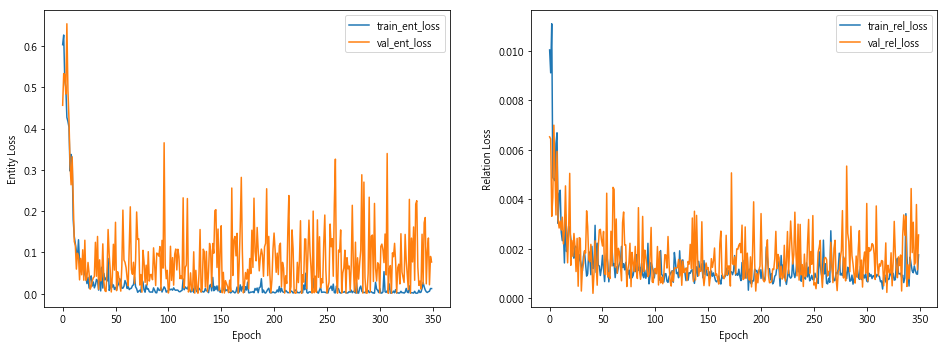

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt


plt.figure(figsize=(16, 12))
plt.subplot(2,2,1)
plt.plot(train_entloss_l, label='train_ent_loss')
plt.plot(val_entloss_l, label='val_ent_loss')
plt.xlabel("Epoch")
plt.ylabel("Entity Loss") 
plt.legend()

plt.subplot(2,2,2)
plt.plot(train_relloss_l, label='train_rel_loss')
plt.plot(val_relloss_l, label='val_rel_loss')
plt.xlabel("Epoch")
plt.ylabel("Relation Loss") 
plt.legend()
plt.show()

In [13]:
import random
def random_choose(input_var):
    r_choose = []
    for i in range(BATCH_SIZE):
        r_choose.append(random.randint(0,len(input_var)))
    return r_choose
        
def ent_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,ent_size).argmax(2)
    return output

def rel_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,MAX_LEN,rel_size).argmax(3)
    return output

In [14]:
# # Check predictions after training
# with torch.no_grad():
#     r_choose = random_choose(input_var)
#     model.eval()
#     ent_output, rel_output = model(input_var[r_choose].cuda() if USE_CUDA else input_var, batch_ent.cuda() \
#                                        if USE_CUDA else batch_ent, isTrain=True)
    
#     batchsize = input_var[r_choose].size(0)
    
#     ent_loss = criterion_tag(ent_output.cpu(), ent_var[r_choose].view(BATCH_SIZE*MAX_LEN))
#     ent_output = ent_argmax(ent_output, batchsize)
    
#     rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
#     print()
#     print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
#     print('true :', index2tag(ent_var[r_choose[0]], ix_to_ent_tag))
    
#     print()
#     print("Entity loss : %.4f" % ent_loss)
#     print("Relation loss : %.4f" % rel_loss)

In [15]:
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('always') 

def evaluate_data(data_loader, raw_input, isTrain=False, silent=False):
    tps, fps, tns, fns = 0, 0, 0, 0
    y_ent_true_all, y_ent_pred_all = [], []
    y_rel_true_all, y_rel_pred_all = [], []
    print_every_batch = 5

    with torch.no_grad():
        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(data_loader):
            model.eval()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain)

            batchsize = batch_x.size(0)

            ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN))
            ent_output = ent_argmax(ent_output, batchsize)

            rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
            rel_output = rel_argmax(rel_output, batchsize)

            
            if not silent:
                print()    
                print("Entity loss : %.4f" % ent_loss)
                print("Relation loss : %.4f" % rel_loss)
                print()
                print('===========================================')
                
#             elif step%print_every_batch==0:
#                 print()    
#                 print("Entity loss : %.4f" % ent_loss)
#                 print("Relation loss : %.4f" % rel_loss)
#                 print()
#                 print('===========================================')
            else:
                pass

            tp, fp, tn, fn, y_true_ent, y_pred_ent, y_true_rel, y_pred_rel = \
            batch_decode(ent_output, rel_output, batch_index, raw_input, batch_ent, batch_rel, silent)
            
            
            
            

            y_ent_true_all.extend(y_true_ent)
            y_ent_pred_all.extend(y_pred_ent)

            y_rel_true_all.extend(y_true_rel)
            y_rel_pred_all.extend(y_pred_rel)
            
            tps += tp
            fps += fp
            tns += tn
            fns += fn
        
        
        print()
        print("Entity detection score")
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        p_r_f1 = precision_recall_fscore_support(y_ent_true_all, y_ent_pred_all, average='micro', 
                                                  labels=range(len(schema['entity'])))
        print('%.3f \t\t %.3f \t\t %.3f \t' % (p_r_f1[0], p_r_f1[1], p_r_f1[2]))
        

        print()
        print("Relation detection score")
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        p_r_f1 = precision_recall_fscore_support(y_rel_true_all, y_rel_pred_all, average='micro', 
                                              labels=range(len(schema['relation'])))
        print('%.3f \t\t %.3f \t\t %.3f \t' % (p_r_f1[0], p_r_f1[1], p_r_f1[2]))
        

        print()
        print("ReferenceEntity+Relation score")
        print("%s \t %s \t %s \t    %s %s %s %s" % ('precision ', 'recall ', 'fbeta_score ', 'tp', 'fp', 'tn', 'fn'))
        p_r_f1 = p_r_fscore(tps, fps, tns, fns)
        print('%.3f \t\t %.3f \t\t %.3f \t\t    %d %d %d %d' % (p_r_f1[0], p_r_f1[1], p_r_f1[2], tps, fps, tns, fns))

            
            
def batch_decode(ent_output, rel_output, batch_index, word_lists, true_ent, true_rel, silent):
    
    eval_ent_list_true_l, eval_rel_list_true_l = [], []
    eval_ent_list_pred_l, eval_rel_list_pred_l = [], []
    
    for e,r,i,te,tr in zip(ent_output, rel_output, batch_index, true_ent, true_rel):
        
        # 算句子長度
        len_of_list = len(word_lists[i])
        word_list = word_lists[i]
        true_ent = index2tag(te, ix_to_ent_tag)[:len_of_list]
        pridict_ent = index2tag(e, ix_to_ent_tag)[:len_of_list]     
        
        # 單句decode關係
        true_r_list, appear_error = decode_rel(te, tr)   # true
        pre_r_list, appear_error = decode_rel(e, r)      # predict
        
        true_r_list = [list(set(i)) if type(i) is list else i for i in true_r_list]
        pre_r_list = [list(set(i)) if type(i) is list else i for i in pre_r_list]
        
        # 出現error，跳過這句
        if appear_error:
            continue
        
        true_r_list = true_r_list[:len_of_list]
        pre_r_list = pre_r_list[:len_of_list]
        
        
        # 評分用
        eval_ent_list_true, err_count = decode_ent(true_ent, schema)
        eval_rel_list_true = decode_rel_to_eval(true_r_list, schema, eval_ent_list_true)
        
        eval_ent_list_pred, err_count = decode_ent(pridict_ent, schema)
        eval_rel_list_pred = decode_rel_to_eval(pre_r_list, schema, eval_ent_list_pred)
        
        if not silent:
            print(word_list)
            print(true_ent)
            print(true_r_list)
            print()
            print('Predict output')
            print(pridict_ent)
            print(pre_r_list)
            print()
            print('True')
            print(eval_ent_list_true)
            print(eval_rel_list_true)
            print('predict')
            print(eval_ent_list_pred)
            print(eval_rel_list_pred)
            print("=====================================")
        
        eval_ent_list_true_l.append(eval_ent_list_true)
        eval_rel_list_true_l.append(eval_rel_list_true)
        eval_ent_list_pred_l.append(eval_ent_list_pred)
        eval_rel_list_pred_l.append(eval_rel_list_pred)
    
    
    e_score, y_true_ent, y_pred_ent = get_scores(eval_ent_list_true_l, eval_ent_list_pred_l, \
                                                 range(len(schema['entity'])),output_y=True)
    r_score, y_true_rel, y_pred_rel = get_scores(eval_rel_list_true_l, eval_rel_list_pred_l, \
                                                 range(len(schema['relation'])),output_y=True)
    
    tp, fp, tn, fn = relation_error_analysis(eval_rel_list_true_l, eval_rel_list_pred_l)
    
    if not silent:
        print('Batch entity score')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(e_score)
        print()
        print('Batch relation score')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(r_score)
        print()
        print('p_r_fscore')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(p_r_fscore(tp, fp, tn, fn), tp, fp, tn, fn)
        print('===========================================')
    
    return tp, fp, tn, fn, y_true_ent, y_pred_ent, y_true_rel, y_pred_rel
        
        



def decode_ent(pred_ent, schema):
    '''
    Aggregate entities from predicted tags
    Input:
    pred_ent=a list of entity tags in a sentence
    schema=the dictionary defining entities and relations
    Output: 
    ent_list=[(ent_start, ent_end, ent_type=eid_in_schema)]
    err_count=the number of bad tags
    '''
    ent_list = []
    ent_start = 0
    ent_end = 0
    state = {
        'ENT_SPAN': 0,
        'NO_ENT': 1
    }
    err_count = 0
    ent_type = ''
    sid = state['NO_ENT']
    for idx, e_tag in enumerate(pred_ent):
        bio = e_tag[0]
        type_tag = e_tag.split('-')[-1]
        if sid == state['NO_ENT']:
            if bio == 'B':
                ent_start = idx
                ent_type = get_eid_from_tag(type_tag, schema)
                sid = state['ENT_SPAN']
            elif bio == 'I':
                err_count += 1
        elif sid == state['ENT_SPAN']:
            if bio != 'I':
                ent_end = idx - 1
                ent_list.append((ent_start, ent_end, ent_type))
                if bio == 'B':
                    ent_start = idx
                    ent_type = get_eid_from_tag(type_tag, schema)
                else:
                    sid = state['NO_ENT']
            elif ent_type != get_eid_from_tag(type_tag, schema):
                ent_end = idx - 1
                ent_list.append((ent_start, ent_end, ent_type))
                err_count += 1
                sid = state['NO_ENT']
    if sid == state['ENT_SPAN']:
        ent_end = len(pred_ent) - 1
        ent_list.append((ent_start, ent_end, ent_type))
    return ent_list, err_count

def get_eid_from_tag(tag, schema):
    '''
    Assume schema is a dictionary in schema.txt
    return eid or -1 if no match is found
    '''
    for content in schema['entity'].values():
        if content['tag'] == tag:
            return content['eid']
    return -1



def decode_rel_to_eval(r_list, schema, ent_list):
    
    max_pair = 0
    for r in r_list:
        if type(r) is list:
            for single_r in r:
                if int(single_r[-3])>max_pair:
                    max_pair = int(single_r[-3])
    

    pair_idx = {}
    for pair in range(max_pair+1):
        for i, r in enumerate(r_list):
            if type(r) is list:
                for single_r in r:
                    if int(single_r[-3])==pair:
                        if pair not in pair_idx:
                            pair_idx[pair] = [i]
                        else:
                            pair_idx[pair].append(i)
    
    
#     # 算兩兩不同tag的數目
#     e_type_dict = {}
#     for e_pair in ent_list:
#         if e_pair[-1] not in e_type_dict:
#             e_type_dict[e_pair[-1]] = 1
#         else:
#             e_type_dict[e_pair[-1]] += 1
    
#     total_pair = 0
#     e_type_l = list(e_type_dict.values())
#     for i, ent_type_num_1 in enumerate(e_type_l):
#         for j, ent_type_num_2 in enumerate(e_type_l[i+1:]):
#             pair_num = ent_type_num_1*ent_type_num_2
#             total_pair += pair_num

    pair_list = []
    for i, e_pair_1 in enumerate(ent_list):
        for j, e_pair_2 in enumerate(ent_list[i+1:]):
            if e_pair_1[-1]!=e_pair_2[-1]:
                pair_list.append([e_pair_1, e_pair_2])
                
                
    
    
    eval_rel_list = []
    for pair in pair_idx:
        rel_loc = pair_idx[pair]
        for e_pairs in pair_list:
            check_pair = True
            first_start = e_pairs[0][0]
            first_end = e_pairs[0][1]
            sec_start = e_pairs[1][0]
            sec_end = e_pairs[1][1]
            
            first_l = list(range(first_start, first_end+1))
            sec_l = list(range(sec_start, sec_end+1))
            combine_l = first_l+sec_l

            
            check_in_entity = []
            for x in combine_l:
                if x in rel_loc:
                    check_in_entity.append(True)
                else:
                    check_in_entity.append(False)
                    check_pair = False
                    break             

            if all(check_in_entity)==True:
                for r in r_list[first_start]:
                    r_info = r.split('-')
                    
                    if int(r_info[1])==pair:
                        r_tag = get_rid_from_tag(r_info[0], schema)
                        e_pairs_copy = e_pairs
                        e_pairs_copy.append(r_tag)
                        eval_rel_list.append(tuple(e_pairs_copy))
    
    return eval_rel_list
    
        
def get_rid_from_tag(tag, schema):   
    for content in schema['relation'].values():
        if content['tag'] == tag:
            return content['rid']




def create_rel_info(ent_output):
    r_list = []     # 存放完整關係
    r_dict = {}     # 記錄關係資訊
    appear_error = False

    pred_ent = index2tag(ent_output, ix_to_ent_tag)
    

    e_loc = 0       # 當前遇到的entity的位置
    for loc, e in enumerate(pred_ent):
        if e[0]=='B':
            e_loc = loc
            r_dict[loc] = {
                '_2ndtag':e[2:],
                'end':loc,
            }
            r_list.append([])
                   
        elif e[0]=='I':
            # 錯誤來自於，entity預測錯誤，沒有預測到B tag，直接跳到I tag
            # 所以沒有紀錄e_loc
            try: 
                r_dict[e_loc]['end'] = loc
            except KeyError:
                appear_error = True
                break
            
            r_list.append([])
            
        else:
            r_list.append("")
              
    return r_list, r_dict, appear_error
        
        
def decode_rel(ent_output, rel_output):

    r_list, r_dict, appear_error = create_rel_info(ent_output) 
    
    IsB = False           # 是否遇到B tag的lock
    IsNext = False        # 是否為B tag後面的tag 的lock
    num_reocrd = -1       # 紀錄pair數
    now_loc = 0
    pre_rel_end_loc = 0
    now_rel_end_loc = 0
    
    rel_keyerror = False
    
    for now in range(len(rel_output)):
        for loc, rel in enumerate(rel_output[now][:now+1]):
            rel = rel.cpu().numpy()
            
#             print(rel, IsB, IsNext)
            
            # 有關係存在，且為B tag 
            if rel!=rel_tag_to_ix[REL_NONE] and IsB==False and IsNext==False:

                IsB = True
                IsNext = True
                tag = ix_to_rel_tag[int(rel)]
                num_reocrd+=1
                now_loc = loc
                
                # 錯誤來自於，now_loc找不到，也就是說，rel預測出來是有關係存在
                # 但預測是'O'
                # 而在entity中卻沒有預測出來，所以r_dict中沒有紀錄
                try:
                    pre_rel_end_loc = r_dict[now_loc]['end']

                except KeyError:
                    rel_keyerror = True
                    break
                    
                
                try:
                    now_rel_end_loc = r_dict[now]['end']
                    
                except KeyError:
                    rel_keyerror = True
                    break
            
             
                second_tag = r_dict[now_loc]['_2ndtag']
                preAorB = check_rel_loc(second_tag, schema)
                nowAorB = 'B' if preAorB=='A' else 'A'
                
                pre_complete_rel = tag+"-"+str(num_reocrd)+"-"+preAorB
                now_complete_rel = tag+"-"+str(num_reocrd)+"-"+nowAorB
                
                # 將以前的token填上關係
                for token in range(now_loc, pre_rel_end_loc+1):
                    
                    # 出現以下error
                    '''AttributeError: 'str' object has no attribute 'append'''
                    # 為 r_list 前處理中沒有給予可能有關係的位置空的list
                    try:
                        r_list[token].append(pre_complete_rel)
                    except AttributeError:
                        r_list[token] = []
                        r_list[token].append(pre_complete_rel)

             
                # 當前token填上關係
                r_list[now].append(now_complete_rel)
                

            
            # 關係前位中B tag後面的tag
            elif rel!=rel_tag_to_ix[REL_NONE] and IsB:
                # 如果還在這個entity的範圍內
                if loc<=pre_rel_end_loc:
                    pass
                
                # 超出現在這個entity的範圍，改lock
                else:
                    IsB = False

            
            # B tag後面的tag的關係，依照前面的關係複製
            elif rel!=rel_tag_to_ix[REL_NONE] and IsNext:
                r_list[now] = r_list[now-1]
                
                
            else:
                if now<=now_rel_end_loc:
                    IsB = False
                else:
                    IsB = False
                    IsNext = False

        
        if rel_keyerror:
            rel_keyerror = False
            break
                
                
    return r_list, appear_error
                

# 是三元關係中的前者還是後者                  
def check_rel_loc(second_tag, schema):
    convert_tag = ''

    for ent_content in schema['entity']:
        if schema['entity'][ent_content]['tag']==second_tag:
            convert_tag = ent_content
    
    rel_types = schema['relation'].values()

    for rel_content in schema['relation'].values():
        for AorB in rel_content['arguments']:
            if rel_content['arguments'][AorB]==convert_tag:
                return AorB
            

            
def get_scores(true_lists, pred_lists, labels, output_y=False):
    y_true, y_pred = [], []
    for t_list, p_list in zip(true_lists, pred_lists):
        yt, yp = align_yt_yp(t_list, p_list, labels)
        y_true.extend(yt)
        y_pred.extend(yp)
        
    scores = precision_recall_fscore_support(y_true, y_pred, average='micro', labels=labels)
    return scores, y_true, y_pred if output_y else scores

def align_yt_yp(truths, predictions, labels):
    '''
    Input:
        truths/predictions: list of true and predicted tuples, 
        with the leading entries as the structure and the last entry as the class,
        e.g., [(e1, e2, rel), ...]
        labels: sequence of valid class
    Output:
        yt: list of true class given a structure
        yp: list of predicted class given a structure
    '''
    yt, yp = [], []
    _ID_NONE = len(labels)
    true_dict = { t[:-1]: t[-1] for t in truths }
    for p in predictions:
        yt.append(true_dict.pop(p[:-1], _ID_NONE))
        yp.append(p[-1])
    for target in true_dict.values():
        yt.append(target)
        yp.append(_ID_NONE)
    return yt, yp



def is_neg_triple(t):
    return np.imag(t[-1]) > 0

def negate_triple(t):
    # Mark negative triples with imaginary relation id
    return (t[0], t[1], np.real(t[-1]).item() + 1j)

def posit_triple(t):
    return (t[0], t[1], np.real(t[-1]).item())

def has_edge(base_ptrs, rel, e):
    '''
    Assume a relation exist between an entity pair, 
    if all the tokens in the base entity point to those in entity e.
    '''
    tok_has_ptr_to_e = [tok_ptrs[rel].ge(e[0]).dot(tok_ptrs[rel].le(e[1])).item() > 0 
                        for tok_ptrs in base_ptrs]
    return len(tok_has_ptr_to_e) > 0 and all(tok_has_ptr_to_e)


def relation_error_analysis(true_rel_lists, rel_lists):
    tp, fp, tn, fn = 0, 0, 0, 0
    for i, r_list in enumerate(rel_lists):
        true_pos = len([t for t in r_list if t in true_rel_lists[i]])
        all_true = len([t for t in true_rel_lists[i] if not is_neg_triple(t)])
        all_pos = len(r_list)
        tp += true_pos
        fn += all_true - true_pos
        fp += all_pos - true_pos
        tn += len([t for t in true_rel_lists[i] if is_neg_triple(t) and posit_triple(t) not in r_list])
    return tp, fp, tn, fn

def p_r_fscore(tp, fp, tn, fn, beta=1, eps=1e-8):
    p = tp / (tp + fp + eps)
    r = tp / (tp + fn + eps)
    f_beta = (1 + beta**2) * ((p * r) / (((beta**2) * p) + r + eps))
    return p, r, f_beta

In [16]:
evaluate_data(dev_loader, raw_input_dev, isTrain=True)


Entity loss : 0.0747
Relation loss : 0.0022

['夏', '季', '時', '兩', '頰', '略', '乾', 'T', '字', '極', '油', ',', '不', '認', '真', '做', '好', '保', '濕', '的', '話', '常', '常', '晚', '上', '妝', '都', '浮', '到', '細', '毛', '上', '了']
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(0, 1, 2)]
[]
predict
[(0, 1, 2)]
[]
['但', '保', '濕', '和', '控', '油', '都', '兼', '具', ',', '所', '以', '特', '別', '推', '薦', '混', '合', '肌', '使', '用', '喔']

['對', '於', '冬', '天', '肌', '膚', '偏', '乾', '的', '我', '似', '乎', '不', '夠', '保', '濕', ',', '需', '要', '再', '加', '強', '前', '後', '的', '化', '妝', '水', '&', '乳', '液', '使', '用']
['O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(2, 3, 2), (14, 15, 0)]
[]
predict
[(2, 3, 2)]
[]
['夏', '天', '用', '太', '黏', '膩', '~', '冬', '天', '的', '話', '會', '不', '夠', '保', '濕', '~', '我', '會', '放', '在', '秋', '天', '當', '保', '濕', '精

['敷', '了', '幾', '天', '痘', '痘', '就', '消', '了', ',', '雖', '然', '她', '說', '味', '道', '怪', '怪', '的', ',', '但', '還', '是', '敷', '得', '很', '開', '心', ',', '尤', '其', '現', '在', '冬', '季', '天', '冷', '又', '乾', '燥', ',', '拿', '來', '敷', '臉', '真', '的', '很', '不', '錯', ',', '皮', '膚', '也', '比', '之', '前', '更', '水', '潤', '白', '析', ',', '毛', '孔', '也', '變', '小', '了', '些', ',', '緊', '緻', '度', '也', '有', '提', '升', ',', '保', '養', '做', '得', '好', '上', '妝', '也', '沒', '煩', '腦', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['夏', '天', '真', '的', '很', '適', '合', '這', '類', '的', '保', '養', ',']
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', '', '', '', '', '', '', '']

True
[(0, 1, 2)]
[]
predict
[(0, 1, 2)]
[]
['所', '以', '每', '次', '擦', '拭', '完', '全', '臉', '後', ',', '我', '都', '還', '會', '在', '加', '強', '的', '擦', '拭', '在', '木', '偶', '紋', '附', '近', ',', '結', '果', '真', '的', '變', '得', '有', '比', '較', '不', '緊', '繃', '了', ',', '但', '是', '其', '他', '部', '位', '却', '沒', '有', '感', '覺', '特', '別', '的', '保', '濕', '與', '鎖', '水', '…', '不', '過', ',', '大', '致', '來', '說', '都', '還', '蠻', '不', '錯', '的', ',', '清', '爽', '的', '質', '地', '蠻', '適', '合', '夏', '天', '使', '用', '的']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

['打', '開', '來', '的', '顏', '色', '竟', '然', '是', '芋', '紫', '色', ',', '嚇', '了', '一', '跳', '說', '~', '不', '過', '香', '味', '不', '會', '太', '香', ',', '一', '抹', '在', '臉', '上', '很', '快', '就', '吸', '收', '了', ',', '一', '點', '都', '不', '黏', '膩', '.', '只', '是', '對', '乾', '性', '肌', '膚', '的', '我', '來', '說', ',', '秋', '冬', '天', '還', '是', '要', '加', '道', '保', '濕', '精', '華', '液', '的', '手', '續', '才', '夠', '保', '濕', '.', '夏', '天', '使', '用', '感', '很', '不', '錯', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['我', '是', '混', '合', '肌', '.', '.', '.', '最', '怕', '使', '用', '保', '濕', '的', '東', '西', '.', '.', '油', '油', '又', '黏', '黏', '的', '.', '.']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(2, 4, 1)]
[]
predict
[(2, 4, 1)]
[]
['用', '了', '約', '半', '瓶', ',', '臉', '部', '保', '濕', '變', '高', ',', '臉', '也', '變', '的', '明', '亮', ',', '不', '過', '夏', '天', '我', '肌', '膚', '較', '容', '易', '出', '油', '的', '膚', '質', ',', '變', '的', '更', '明', '顯', '了']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O

['夏', '天', '想', '要', '保', '濕', '又', '怕', '油', '膩', '的', '大', '大', '們', ',', '這', '會', '是', '你', '絕', '佳', '的', '選', '擇', '歐', ',', '推', '薦', '給', '大', '家', '使', '用', '看', '看', '歐']
['B-SEAS', 'I-SEAS', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-SEAS', 'I-SEAS', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[

['我', '是', '乾', '性', '敏', '感', '肌', '膚', '.', '櫃', '姐', '叫', '我', '一', '定', '要', '注', '重', '保', '濕', 'X', 'D']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(4, 7, 1)]
[]
predict
[(4, 7, 1)]
[]
['冬', '天', '時', '我', '的', '肌', '膚', '又', '特', '別', '容', '易', '乾', '癢', ',', '擦', '了', '好', '幾', '道', '的', '保', '濕', '不', '僅', '不', '夠', '還', '得', '再', '擦', '上', '厚', '厚', '的', '乳', '霜', ',', '有', '時', '還', '是', '會', '很', '難', '上', '妝']
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

['這', '款', '保', '濕', '化', '妝', '水', '很', '天', '然', ',', '目', '前', '季', '節', '正', '在', '轉', '換', ',', '我', '的', '皮', '膚', '秋', '冬', '時', '會', '偏', '乾', ',', '這', '瓶', '化', '妝', '水', '解', '決', '了', '我', '皮', '膚', '乾', '燥', '的', '問', '題', ',', '並', '且', '接', '著', '上', '精', '華', '液', '很', '好', '吸', '收', ',', '有', '時', '我', '會', '濕', '敷', '它', '候', ',', '在', '上', '妝', '會', '很', '服', '貼', '.', '我', '想', '我', '會', '繼', '續', '用', '第', '二', '瓶', ',', '保', '濕', '的', '效', '果', '我', '很', '滿', '意']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O'

['香', '味', '清', '淡', ',', '使', '用', '起', '來', '很', '水', '潤', ',', '又', '不', '黏', '膩', ',', '比', '一', '般', '保', '濕', '化', '妝', '水', '保', '濕', ',', '卻', '又', '不', '會', '使', '皮', '膚', '出', '油', ',', '很', '好', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O'

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O

['因', '為', '每', '當', '在', '換', '季', '時', ',', '敏', '感', '性', '肌', '膚', '總', '是', '會', '因', '為', '季', '節', '變', '化', '而', '引', '起', '肌', '膚', '不', '適', ',', '尤', '其', '冬', '天', '容', '易', '有', '乾', '癢', '的', '情', '形', ',', '所', '以', '這', '時', '的', '保', '養', ',', '總', '要', '特', '別', '注', '重', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 

['這', '次', '試', '用', '全', '效', '舒', '緩', '精', '華', '液', ',', '令', '敏', '感', '肌', '的', '我', '很', '滿', '意', '它', '的', '效', '果']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '']

True
[(13, 15, 1)]
[]
predict
[(6, 7, 0), (13, 15, 1)]
[((6, 7, 0), (13, 15, 1), 0)]
['不', '過', '對', '於', '偏', '乾', '性', '的', '我', '來', '說', ',', '冬', '天', '他', '可', '能', '就', '不', '太', '保', '濕', '滋', '潤', '了']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', '

['因', '為', '本', '身', '是', '敏', '感', '肌', '的', '關', '係', ',', '使', '用', '美', '白', '類', '的', '產', '品', '特', '別', '注', '意', '小', '心', '~']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(5, 7, 1)]
[]
predict
[(5, 7, 1)]
[]
['3', '.', '我', '是', '乾', '燥', '肌', '.', '對', '於', '不', '夠', '保', '濕', '的', '產', '品', '不', '是', '擦', '了', '有', '緊', '繃', '感', '難', '推', '勻', '.', '就', '是', '會', '卡', '粉', '抬', '頭', '紋']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

In [17]:
# load test set

input_test, ent_test, rel_test, raw_index_test, raw_input_test = dev_preprocess(test_data)
test_loader = dataload(input_test, ent_test, rel_test, raw_index_test)

In [18]:
evaluate_data(test_loader, raw_input_test, isTrain=True, silent=True)


Entity detection score
precision  	 recall  	 fbeta_score  	
0.875 		 0.860 		 0.867 	

Relation detection score
precision  	 recall  	 fbeta_score  	
0.600 		 0.588 		 0.594 	

ReferenceEntity+Relation score
precision  	 recall  	 fbeta_score  	    tp fp tn fn
0.600 		 0.588 		 0.594 		    57 38 0 40


In [19]:
def continue_train():
    
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    criterion_tag = nn.NLLLoss(ignore_index=ent_tag_to_ix[PAD_TAG])
    criterion_rel = nn.NLLLoss(ignore_index=rel_tag_to_ix[REL_PAD])
    
    n_iters = 150
    print_every = 12

    train_entloss_l = []
    val_entloss_l = []
    train_relloss_l = []
    val_relloss_l = []

    loss = 0
    
    for epoch in tqdm(range(n_iters)):  
        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
            model.train()
            optimizer.zero_grad()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain=True)

            batchsize = batch_x.size(0)

            batch_ent = batch_ent.view(batchsize*MAX_LEN)
            batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)

            entloss = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
            relloss = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
            loss = entloss+relloss

            loss.backward()
            optimizer.step()


        train_entloss_l.append(entloss.cpu())
        train_relloss_l.append(relloss.cpu())
        #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))

        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
            model.eval()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain=True)

            batchsize = batch_x.size(0)

            val_entloss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
            val_relloss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))

        val_entloss_l.append(val_entloss.cpu())
        val_relloss_l.append(val_relloss.cpu())

        
        
#         evaluate_data(loader, raw_input, isTrain=True, silent=True)
        
        print()
        print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
              % (epoch+1, entloss, relloss, loss))
        print("      %s  | val ent loss %.4f | val rel loss %.4f"
              % (" "*len(str(epoch+1)), val_entloss, val_relloss))
        

In [20]:
# continue_train()

In [21]:
# evaluate_data(dev_loader, raw_input_dev, isTrain=True)

In [22]:
# evaluate_data(test_loader, raw_input_test, isTrain=True, silent=True)

In [23]:
evaluate_data(dev_loader, raw_input_dev, isTrain=False)


Entity loss : 0.0928
Relation loss : 0.0052

['一', '般', '性', '肌', '膚', '在', '冬', '季', '時', '我', '想', '保', '濕', '度', '很', '足', '夠', '也', '不', '會', '黏', '膩']
['O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', [], [], '', '', '', [], [], [], '', '', '', '', '', '', '', '']

True
[(6, 7, 2), (11, 13, 0)]
[((6, 7, 2), (11, 13, 0), 1)]
predict
[(6, 7, 2), (11, 13, 0)]
[]
['保', '濕', '的', '部', '份', '倒', '是', '覺', '得', '還', '可', '以', ',', '是', '有', '感', '覺', '比', '較', 'Q', '彈', '一', '點', ',', '夏', '天', '裡', '開', '冷', '氣', '常', '會', '讓', '皮', '膚', '太', '乾', ',', '但', '擦', '了', '這', '款',

['夏', '天', '用', '太', '黏', '膩', '~', '冬', '天', '的', '話', '會', '不', '夠', '保', '濕', '~', '我', '會', '放', '在', '秋', '天', '當', '保', '濕', '精', '華', '用']
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
[[], [], '', '', '', '', '', [], [], '', '', '', '', '', [], [], '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '']

Predict output
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', [], [], '', '', '', '', '', ['ApplyIn-1-A'], ['ApplyIn-1-A'], '', '', '', '', '', ['ApplyIn-1-B'], ['ApplyIn-1-B'], '', '', '', '', '', '']

True
[(0, 1, 2), (7, 8, 2), (14, 15, 0), (21, 22, 2), (24, 25, 0)]
[((21, 22, 2), (24, 25, 

['整', '體', '來', '說', '保', '濕', '度', '還', '可', '以', ',', '但', '推', '薦', '夏', '天', '使', '用', ',', '冬', '天', '可', '能', '不', '夠', '力', ',', '吸', '收', '度', '還', '不', '錯', ',', '但', '我', '白', '天', '用', '了', '這', '瓶', '乳', '液', '之', '後', '變', '的', '很', '容', '易', '出', '油', ',', '所', '以', '我', '都', '晚', '上', '睡', '覺', '時', '才', '用']
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['不', '過', '對', '於', '偏', '乾', '性', '的', '我', '來', '說', ',', '冬', '天', '他', '可', '能', '就', '不', '太', '保', '濕', '滋', '潤', '了']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', [], [], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', [], [], '', '', '']

True
[(12, 13, 2), (20, 21, 0)]
[]
predict
[(12, 13, 2), (20, 21, 0)]
[]
['夏', '天', '真', '的', '很', '適', '合', '這', '類', '的', '保', '養', ',']
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[]

['保', '濕', '度', '中', '等', '.', '不', '過', '冬', '天', '可', '能', '不', '合', '適', '.']
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], '', '', '', '', '', [], [], '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-A'], ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '']

True
[(0, 2, 0), (8, 9, 2)]
[]
predict
[(0, 2, 0), (8, 9, 2)]
[((0, 2, 0), (8, 9, 2), 1)]
Batch entity score
precision  	 recall  	 fbeta_score  	
(0.9354838709677419, 0.8923076923076924, 0.9133858267716536, None)

Batch relation score
precision  	 recall  	 fbeta_score  	
(0.5294117647058824, 0.47368421052631576, 0.5, None)

p_r_fscore
precision  	 recall  	 fbeta_score  	
(0.5294117643944637, 0.4736842102770083, 0.4999999947376544) 9 8 0 10

Entity loss : 0.0419
Relation loss : 0.0048

['

['『', 'E', 'V', 'I', 'T', 'A', '玫', '瑰', '泡', '沫', '潔', '顏', '慕', '斯', '』', '內', '含', '蜂', '王', '乳', '萃', '取', '精', '華', '、', '膠', '原', '蛋', '白', '、', '雙', '重', '玻', '尿', '酸', '、', '玫', '瑰', '水', '等', '成', '分', ',', '很', '適', '合', '肌', '膚', '外', '油', '內', '乾', '的', '我', ',', '最', '近', '剛', '好', '從', '炙', '熱', '的', '夏', '天', '轉', '換', '成', '秋', '季', ',', '正', '需', '要', '開', '始', '加', '強', '肌', '膚', '的', '保', '溼', '工', '作', ',', '就', '先', '從', '洗', '臉', '步', '驟', '做', '起']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '',

['很', '喜', '歡', '本', '產', '品', '清', '爽', '不', '黏', '膩', '的', '感', '覺', '很', '適', '合', '敏', '感', '性', '膚', '質', '的', '我', '對', '兩', '頰', '的', '保', '濕', '效', '果', '很', '好', '但', '對', '於', '原', '本', '鼻', '子', '兩', '側', '乾', '癢', '的', '狀', '況', '及', '消', '除', '細', '紋', '並', '無', '太', '大', '改', '善', '整', '體', '來', '說', '是', '個', '保', '濕', '性', '良', '好', '的', '產', '品']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '

['這', '款', '保', '濕', '化', '妝', '水', '很', '天', '然', ',', '目', '前', '季', '節', '正', '在', '轉', '換', ',', '我', '的', '皮', '膚', '秋', '冬', '時', '會', '偏', '乾', ',', '這', '瓶', '化', '妝', '水', '解', '決', '了', '我', '皮', '膚', '乾', '燥', '的', '問', '題', ',', '並', '且', '接', '著', '上', '精', '華', '液', '很', '好', '吸', '收', ',', '有', '時', '我', '會', '濕', '敷', '它', '候', ',', '在', '上', '妝', '會', '很', '服', '貼', '.', '我', '想', '我', '會', '繼', '續', '用', '第', '二', '瓶', ',', '保', '濕', '的', '效', '果', '我', '很', '滿', '意']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O'

['前', '兩', '個', '禮', '拜', ',', '因', '為', '氣', '溫', '變', '化', ',', '鼻', '頭', '有', '點', '脫', '屑', ',', '將', '精', '華', '液', '倒', '多', '一', '點', '敷', '在', '鼻', '頭', ',', '馬', '上', '就', '可', '改', '善', '脫', '屑', '的', '問', '題', ',', '且', '很', '保', '濕', ',', '對', '於', '敏', '感', '性', '膚', '質', '(', '我', '兩', '頰', '很', '容', '易', '泛', '紅', '敏', '感', ')', '也', '很', '適', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', ''

['因', '為', '本', '身', '是', '敏', '感', '肌', '的', '關', '係', ',', '使', '用', '美', '白', '類', '的', '產', '品', '特', '別', '注', '意', '小', '心', '~']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(5, 7, 1)]
[]
predict
[(5, 7, 1)]
[]
['待', '在', '冷', '氣', '房', '的', 'O', 'L', '都', '知', '道', '即', '使', '夏', '天', '油', '水', '更', '不', '平', '衡', '所', '以', '臉', '部', '的', '乾', '感', '會', '更', '明', '顯', ',', '油', '感', '也', '會', '更', '凸', '顯', ',', '用', '了', '這', 'S', 'U', 'R', 'P', 'U', 'R', '後', '混', '和', '肌', '的', 'T', '字'

['對', '於', '冬', '天', '肌', '膚', '偏', '乾', '的', '我', '似', '乎', '不', '夠', '保', '濕', ',', '需', '要', '再', '加', '強', '前', '後', '的', '化', '妝', '水', '&', '乳', '液', '使', '用']
['O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(2, 3, 2), (14, 15, 0)]
[]
predict
[(2, 3, 2)]
[]
['隔', '一', '天', '做', '普', '通', '化', '妝', '棉', '的', '拍', '打', '保', '養', ':', '一', '點', '都', '不', '黏', '且', '清', '爽', ',', '保', '溼', '的

['我', '是', '混', '合', '肌', ',', '兩', '頰', '稍', '乾', ',', '那', '部', '分', '若', '沒', '加', '強', '保', '濕', ',', '直', '接', '使', '用', '這', '瓶', '會', '有', '點', '乾', '燥', '的', '感', '覺']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(2, 4, 1)]
[]
predict
[(2, 4, 1)]
[]
['我', '是', '乾', '性', '敏', '感', '肌', '膚', '.', '櫃', '姐', '叫', '我', '一', '定', '要', '注', '重', '保', '濕',

['所', '以', '每', '次', '擦', '拭', '完', '全', '臉', '後', ',', '我', '都', '還', '會', '在', '加', '強', '的', '擦', '拭', '在', '木', '偶', '紋', '附', '近', ',', '結', '果', '真', '的', '變', '得', '有', '比', '較', '不', '緊', '繃', '了', ',', '但', '是', '其', '他', '部', '位', '却', '沒', '有', '感', '覺', '特', '別', '的', '保', '濕', '與', '鎖', '水', '…', '不', '過', ',', '大', '致', '來', '說', '都', '還', '蠻', '不', '錯', '的', ',', '清', '爽', '的', '質', '地', '蠻', '適', '合', '夏', '天', '使', '用', '的']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['敷', '了', '幾', '天', '痘', '痘', '就', '消', '了', ',', '雖', '然', '她', '說', '味', '道', '怪', '怪', '的', ',', '但', '還', '是', '敷', '得', '很', '開', '心', ',', '尤', '其', '現', '在', '冬', '季', '天', '冷', '又', '乾', '燥', ',', '拿', '來', '敷', '臉', '真', '的', '很', '不', '錯', ',', '皮', '膚', '也', '比', '之', '前', '更', '水', '潤', '白', '析', ',', '毛', '孔', '也', '變', '小', '了', '些', ',', '緊', '緻', '度', '也', '有', '提', '升', ',', '保', '養', '做', '得', '好', '上', '妝', '也', '沒', '煩', '腦', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['皮', '膚', '乾', '燥', '狀', '況', '就', '馬', '上', '得', '到', '舒', '緩', ',']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '']

True
[(0, 3, 1), (11, 12, 0)]
[((0, 3, 1), (11, 12, 0), 0)]
predict
[(0, 3, 1), (11, 12, 0)]
[((0, 3, 1), (11, 12, 0), 0)]
['這', '項', '產', '品', '使', '用', '起', '來', '清', '爽', '無', '負', '擔', '保', '濕', '效', '果', '又', '好', '真', '的', '超', '適', '合', '夏', '天', '使', '用', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O']
['', 

In [24]:
evaluate_data(test_loader, raw_input_test, isTrain=False, silent=True)


Entity detection score
precision  	 recall  	 fbeta_score  	
0.874 		 0.872 		 0.873 	

Relation detection score
precision  	 recall  	 fbeta_score  	
0.760 		 0.600 		 0.671 	

ReferenceEntity+Relation score
precision  	 recall  	 fbeta_score  	    tp fp tn fn
0.760 		 0.600 		 0.671 		    57 18 0 38


In [25]:
len(input_var), len(input_dev), len(input_test)

(788, 101, 200)